DEFINIZIONI
---

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob
from uncertainties import ufloat, unumpy, umath
import matplotlib.dates as mdates


#REFERENCE PER LE FORMULE: Wanninkhof, Rik, Relationship between wind 
#speed and gas exchange over the ocean revisited 2014

#columname must be a str
def check_dataframe_not_empty(df, columname):
    if len(df[columname]) != 0:
        return True
    else:
        return False


#simplified version, formula 6 from W14
def simplified_fluxes(av_square_u10, deltaPCO2):
    #fattore moltiplicativo
    factor = 7.7*(10**-4)
    
    return factor*av_square_u10*deltaPCO2


#formula 5 from W14
def fluxes(av_square_u10, deltaPCO2, sol, Sc):
    
    
    A=0.251 #è in cm/h + (m/s)^2
    
    return A*av_square_u10*sol*((Sc/660)**-0.5)*deltaPCO2

#from W14
def schmidt_number(T):
    
    #coefficients for CO2
    A = 2116.8
    B = -136.25
    C = 4.7353
    D = -0.092307
    E = 0.0007555
    
    
    
    return A + B*T + C*(T**2) + D*(T**3) + E*(T**4)
    

def gas_transfer_velocity(av_sq_u10, Sc):
        
  
        A=0.251 #K è in cm/h + U**2 = (m/s)^2
        
        return A*av_sq_u10*((Sc/660)**-0.5)
    
    
#SOLUBILITà  SEMPRE WANNIKLHOF    
#T in K e S in per thousand 

#BETA in mol L-1 atm -1
def sol(T, S):
    A1 = -58.0931
    A2 = 90.5069
    A3 = 22.2940
    B1 = 0.027766
    B2 = -0.025888
    B3 = 0.0050578

    lnBETA = A1 + A2*(100/T) + A3*np.log(T/100) + S*(B1 + B2*(T/100) + B3*((T/100)**2))
    
    return np.exp(lnBETA)


#different Units

#BETA in mol kg-1 atm -1

def sol_var(T, S):
    A1 = -60.2409
    A2 = 93.4517
    A3 = 23.3585
    B1 = 0.023517
    B2 = -0.023656
    B3 = 0.0047036

    lnBETA = A1 + A2*(100/T) + A3*np.log(T/100) + S*(B1 + B2*(T/100) + B3*((T/100)**2))
    
    return np.exp(lnBETA)

    
#calcolo della pressione parziale a partire dalla frazione molare XCO2, dalla press atm P e dalla press di vap sat

#formula 6 of FluxEngine: A flexible processing system for calculating atmosphere-ocean carbon dioxide gas fluxes 
#and climatologies
def pCO2_func(xCO2, P, pH2O):
    
    #result in mb, given P and pH2O in mbar
 
    pCO2_mb = xCO2*(P-pH2O)
    
    #to convert in uatm i divide by 1013.15
    pCO2_atm = pCO2_mb/1013.25
    
    #multiply by 10^6 to obtain UATM
    return pCO2_atm*1000000






#formula 7 di FluxEngine: A flexible processing system for calculating atmosphere-ocean carbon dioxide gas fluxes 
#and climatologies --> è sbagliata, la corretta è in weiss e price 1980, convertita in mb tramite A
#SST in K, S in per thousand:
def press_H2O(SST_k, S):
    
    #mi definisco un fattore alla volta per semplicità
    A = 1013.15
    B = 24.4543
    C = 67.4509
    D = 4.8489
    E = 0.000544
    
    return A*np.exp(B - C*(100/SST_k) - D*np.log(SST_k/100) - E*S) #in MBAR
    
    
#flux unit conversion
#from  cm/h * mol/(L*atm) * uatm o kg/(s*m2)
#conversion of mol/L knowing that L = 10^-3 m^3 and that 1mol of CO2 correspond to 44.01 g --> 44.01 * 10^-3 kg
#h is 3.6*10^-3 s, cm is 10^-2 m, uatm is 10^-6 atm
def convert_flux(flux_in):
    
    #result in kg/(s*m2)
    return flux_in*44.01*(10**-11)/3.6


#simplified formula is in mol/(yr*m2)
#convert mol to kg using 44.01*10^-3
#convert yr to s using 365.2425*24*3600 (365.2425 is the average year lenght)

def convert_simp_flux(simp_flux_in):
    
    #il risultato è in kg/(s*m2)
    return simp_flux_in*44.01*(10**-3)/31556952.0




#same for simplified
def convert_simp_flux_mmol_h(simp_flux_in):
    
    #il risultato è in mmol/(hr*m2)
    return simp_flux_in*(10**3)/8765.82
    
    
#convert from cm/h * mol/(L*atm) * uatm to  mmol/(hr*m2)
def convert_flux_mmol_d(flux_in):
    
    #con questa conversione mi da il risultato in mmol/(hr*m2)
    return flux_in*(10**-2)*24




#different way of expressing the flux (with K computed with the function above)
def fluxes_K(pw, pa, sol, K):
    
    return K*sol*(pw-pa)


#to round to the closest exact hour
def round_hr(date):
    if date.minute >= 30:
        return date.replace(hour= date.hour + 1, minute = 0, second=0)
    else:
        return date.replace(hour = date.hour, minute=0, second=0)


#convert water co2 in ppm to pco2 in uatm (pro-cv user guide)

def co2_ppm_to_uatm(co2_ppm, gas_stream_pressure):
    return co2_ppm*gas_stream_pressure/1013.25


Data reading
---

INTERPOLATION AND INTERPOLATION UNCERTAINTIES
---

In [16]:
#i start from daily data filtered with the 3-sigma filter and averaged
#i drop co2 columns (i'm interested in pco2 only...) and the ufloat column that i have to construct again after reading

#contains pco2, sst and sss
buoy_daily = pd.read_csv("./pCO2_CTD_FULL_DAILY_20240711.csv", usecols = ["date", "temp", "sal", "pco2", "pco2_err", "co2_averaged_err"] ,converters={"date": pd.to_datetime})

#convert columns to float

for cols in ["temp", "sal", "pco2", "pco2_err", "co2_averaged_err"]:
    buoy_daily[cols] = buoy_daily[cols].astype(float)

#ufloat format
buoy_daily["pco2_w_err"] = buoy_daily.apply(lambda x: ufloat(x.pco2, x.pco2_err), axis = 1)

#i now want to interpolate nan values in temp, sal and pco2 columns using a simple linear interpolation

buoy_daily["interp_T"] = buoy_daily.temp.interpolate(method = "linear", limit_area="inside")   
buoy_daily["interp_S"] = buoy_daily.sal.interpolate(method = "linear", limit_area="inside")
buoy_daily["interp_pco2"] = buoy_daily.pco2.interpolate(method = "linear", limit_area="inside")


INTERPOLATION UNCERTANTIES


In [46]:
#i need to find the gap size of the missing values and the distance from the last available value

nan_indexs = buoy_daily[buoy_daily.pco2_err.isna()].index

index = []
gap_size = []

i=0

while i < len(buoy_daily):

    #i define counter and half lenght that need to be initialized at each gap
    counter = 0

    if i in nan_indexs:


        #checkin the lenght of the gap
        for j in range(i, len(buoy_daily)):
            #print(j)

            #check if is the first element of the gap
            if j+1 in nan_indexs and j-1 not in nan_indexs:
                #print("starting gap", j)

                #i simply start the counter and go to the next element
                #add the index of the gap
                index.append(i)

                counter +=1
                

            #middle element
            elif j+1 in nan_indexs and j-1 in nan_indexs:
                #print("middle gap", j)
                #i increase the counter and go to the next element  
                counter +=1
            

            #i have to check the last one element of the series
            elif j+1 not in nan_indexs and j-1 in nan_indexs:
                #print("ending gap", j)
                counter +=1 
                #i have to assign the gap size
                gap_size.append(counter)

                i = j+1
                
                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

            #single element: other combinations...
            else:
                #print("single element or something else?", j)
                counter +=1
                index.append(i)
                gap_size.append(counter)

                i +=1

                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

    else:
        i +=1



#i compute the max std on the pco2 on a moving window varying from 1 to 22 (max gap size) and I use to estimate the
#uncertainty on the pco2

#+1 to the max value because the range function does not include the last value
gap_sizes = range(2, max(gap_size)+1)
std_pco2 = []

for gap in gap_sizes:
    std_pco2.append(buoy_daily["pco2"].rolling(window=gap, min_periods=1).std().max())

#save in a dataframe
std_pco2_df = pd.DataFrame({"gap_size": gap_sizes, "std_pco2": std_pco2})    


In [47]:
#i assign the uncertainties from std_pco2_df to the gaps


#i want to add an error to pco2 gaps based on the max standard deviation of the variable found in the dataframe 
#in winddow of the size of the gap

#i have them stored in the std_pco2_df dataframe

#index contains the index of the first element of the gap in pco2_err
#for each gap i simply assgign the std_pco2 value correspoding to the max variability (std) over all the dataset for a moving window of the lenght equal to  a value to all the elements of the gap

for i in range(0, len(index)):
    #print("index", index[i], "gap size", gap_size[i], "half lenght", half_lenght[i])

    #starting from the first element of the gap i cycle through the gap and I assign the uncertainty of the gap

    #if I have just a single element in the gap I do not need to cycle, I simply assinging the value (but i have to consider the lenght as 2, because the gap size is 1 and no stdev for1 element)
    if gap_size[i] == 1:
        buoy_daily.loc[index[i], "pco2_err"] = std_pco2_df[std_pco2_df["gap_size"] == gap_size[i] +1]["std_pco2"].values[0]

    #if the gap size is greater than 1, I have to cycle through the gap
    else:
        for j in range(0, gap_size[i]):

            buoy_daily.loc[index[i]+j, "pco2_err"] = std_pco2_df[std_pco2_df["gap_size"] == gap_size[i]]["std_pco2"].values[0]


In [49]:
#i now save again the buoy_daily dataframe with the new uncertainties, so that the next time I can directly read this file
#buoy_daily.to_csv("./buoy_24h_interp_w_errors_20240711.csv", index=False)

SAME FOR WIND DATA (PRESSURE NEED TO BE INTERPOLATE; WIND DATA FROM OBS AND CCMP)

read ccmp data

In [37]:
#ccmp wind data to fill the gaps
#ccmp_df created with the other notebook

ccmp_6h = pd.read_csv("ccmp_df.csv", converters={'time': pd.to_datetime})

#from ccmp i only need wind speed, time and number of observations, drop the rest
#some dates (10 total) are with nan on the uwnd and wvnd and have u v and w values.. i don't know what to do with them, so i drop them (what is w?) and they have a huge n_obs value (why?)

ccmp_6h = ccmp_6h[["time", "uwnd", "vwnd", "nobs"]]

#drop nan
ccmp_6h.dropna(inplace = True)

#and rename time to date
ccmp_6h.rename(columns = {"time": "date"}, inplace = True)
#i compute wind speed from u and v components using pythagoras
ccmp_6h["wspd"] = np.sqrt(ccmp_6h["uwnd"]**2 + ccmp_6h["vwnd"]**2)

#i now merge insitu (meteo_6h) and ccmp data to compare them
#wind = pd.merge(meteo_6h, ccmp_df, on= "date", how = "inner")

read insitu 1h data and than averaged on 6h to be compatible with ccmp

In [38]:
#wind and pressure data. pressure data are from 50 m asl. I subtract 5 hPa to make them sea-surface like data
meteo = pd.read_csv("", usecols = ["year", "month", "day", "hour", "p(mbar)", "u(m/s)"])

#drop nan
meteo.dropna(inplace = True)
meteo.reset_index(drop=True, inplace=True)

#i construct the date (apply raised error... so...)

for i in range(0, len(meteo)):
    meteo.loc[i, "date"] = dt.datetime(int(meteo.year[i]), int(meteo.month[i]), int(meteo.day[i]), int(meteo.hour[i]))

In [39]:
#P has a 0.25 hPa uncertainty (equivalent to 0.25 mbar)
#i construct the ufloat column for P

meteo["p_w_err"] = meteo.apply(lambda x: ufloat(x["p(mbar)"], 0.25), axis = 1)

#i then average on 6 hours to check with ccmp data

date_in = dt.datetime(2021,12,1)
date_fin = dt.datetime(2023,6,30)

delta = dt.timedelta(hours = 6)

press = []
date = []
wind = []
n_data = []

while date_in <= date_fin:

    app = meteo[(meteo.date >= date_in) & (meteo.date < date_in + delta)]

    #æt least 3 data over 6 hours
    if len(app) > 3:
        press.append(app.p_w_err.values.mean())
        wind.append(app["u(m/s)"].mean())
        date.append(date_in)
        n_data.append(len(app))

    date_in += delta


meteo_6h = pd.DataFrame({"date": date, "p_w_err": press, "wind": wind, "n_data": n_data})

In [42]:
#I now create a df with the wind speed from measurements and filling the gaps with ccmp data, i will specify the source of the data in a column
date_in = buoy_daily["date"][0]
date_fin = buoy_daily["date"].iloc[-1]
ccmp_used = []

#i use the last day of the meteo dataframe that i need pressure data to interpolate until the last day of the buoy data (which are nan pressure data)
#date_fin = meteo_6h["date"].iloc[-1]

time_index = pd.date_range(start = date_in, end = date_fin, freq = "6H")

# Create an empty dataframe with the required columns
meteo_6h_fin = pd.DataFrame(columns=['date', 'wspd', 'wind_type', 'press'])
count = 0

# Iterate through the dates in time_index
for date in time_index:
    # Check if the date is in meteo_6h dataframe
    if date in meteo_6h['date'].values:
        # Get the corresponding wind speed and pressure values from meteo_6h dataframe
        wind_speed = meteo_6h.loc[meteo_6h['date'] == date, 'wind'].values[0]
        pressure = meteo_6h.loc[meteo_6h['date'] == date, 'p_w_err'].values[0]
        # Add the row to the new dataframe with wind_type as 'observed'
        meteo_6h_fin.loc[count] = [date, wind_speed, 'observed', pressure]
    else:
        # Get the corresponding wind speed value from ccmp_6h dataframe
        wind_speed = ccmp_6h.loc[ccmp_6h['date'] == date, 'wspd'].values[0]
        # Interpolate the pressure value using linear interpolation
        pressure = np.nan
        # Add the row to the new dataframe with wind_type as 'ccmp'
        meteo_6h_fin.loc[count] = [date, wind_speed, 'ccmp', pressure]
        ccmp_used.append(date)

    count += 1




In [58]:
#i need the squared of the wind speed for the computation of the fluxes, so i square before to average on a daily basis
meteo_6h_fin["u2"] = meteo_6h_fin.apply(lambda x: x.wspd**2, axis = 1)

#daily mean (manually because i have to consider the uncertainty)

date = []
press = []
wind = []
n_data = []
u2 = []

date_in = dt.datetime(2021,12,1)
date_fin = dt.datetime(2023,6,30)

delta = dt.timedelta(days = 1)

while date_in <= date_fin:
    
        app = meteo_6h_fin[(meteo_6h_fin.date >= date_in) & (meteo_6h_fin.date < date_in + delta)]
    
        #æt least 2 data over 4 6h slices (doesn make sense because the use of ccmp has filled all the missing wind data, so it will always be full, even if press is nan, but press is slow-varying so sticazzi)
        if len(app) > 0:
            press.append(app.press.values.mean())
            wind.append(app.wspd.mean())
            date.append(date_in)
            n_data.append(len(app))
            u2.append(app.u2.mean())
    
        date_in += delta

meteo_daily = pd.DataFrame({"date": date, "p_w_err": press, "wind": wind, "u2": u2, "n_data": n_data})

In [ ]:
#I divide nominal value and uncertainty of p_w_err, but i need to for cycle to avoid nans
p = []
p_err = []

for i in range(0, len(meteo_daily)):

    try:
        p.append(meteo_daily.p_w_err[i].nominal_value)
        p_err.append(meteo_daily.p_w_err[i].std_dev)
        #if meteo_daily.p_w_err.n.isna() == True:
            #p.append(np.nan)
            #p_err.append(np.nan)

        #else:
        #    p.append(meteo_daily.p_w_err[i].nominal_value)
        #    p_err.append(meteo_daily.p_w_err[i].std_dev)

    except:
        print("problem", i)
        p.append(np.nan)
        p_err.append(np.nan)

meteo_daily["p"] = p
meteo_daily["p_err"] = p_err

meteo_daily["interp_P"] = meteo_daily["p"].interpolate(method = "linear", limit_area="inside")

#for some reason i have a non-nan pressure error even if my pressure is nan (probabily i have some nans in at lest one of the 4 6h values), i set the error to nan where the pressure is nan
meteo_daily.loc[meteo_daily.p.isna(), "p_err"] = np.nan


In [60]:
#i want to assign the error on the rpessure using a similar procedure to the one used for the pco2 errors
#i have few gaps, max 2 consecutive days, so i can use the same procedure


#find the gaps

#i need to find the gap size of the missing values and the distance from the last available value

nan_indexs = meteo_daily[meteo_daily.p_err.isna()].index

index = []
gap_size = []

i=0

while i < len(meteo_daily):

    #i define counter and half lenght that need to be initialized at each gap
    counter = 0

    if i in nan_indexs:


        #checkin the lenght of the gap
        for j in range(i, len(meteo_daily)):
            #print(j)

            #check if is the first element of the gap
            if j+1 in nan_indexs and j-1 not in nan_indexs:
                #print("starting gap", j)

                #i simply start the counter and go to the next element
                #add the index of the gap
                index.append(i)

                counter +=1
                

            #middle element
            elif j+1 in nan_indexs and j-1 in nan_indexs:
                #print("middle gap", j)
                #i increase the counter and go to the next element  
                counter +=1
            

            #i have to check the last one element of the series
            elif j+1 not in nan_indexs and j-1 in nan_indexs:
                #print("ending gap", j)
                counter +=1 
                #i have to assign the gap size
                gap_size.append(counter)

                i = j+1
                
                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

            #single element: other combinations...
            else:
                #print("single element or something else?", j)
                counter +=1
                index.append(i)
                gap_size.append(counter)

                i +=1

                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

    else:
        i +=1



#i compute the max std on the pco2 on a moving window varying from 1 to 22 (max gap size) and I use to estimate the
#uncertainty on the pco2

#+1 to the max value because the range function does not include the last value
gap_sizes = range(2, max(gap_size)+1)
std_press = []

for gap in gap_sizes:
    std_press.append(meteo_daily["p"].rolling(window=gap, min_periods=1).std().max())

#save in a dataframe
std_press_df = pd.DataFrame({"gap_size": gap_sizes, "std_press": std_press})    



#i assign the uncertainties from std_press_df to the gaps


#i want to add an error to pco2 gaps based on the max standard deviation of the variable found in the dataframe 
#in winddow of the size of the gap

#i have them stored in the std_press_df dataframe

#index contains the index of the first element of the gap in p_err
#for each gap i simply assgign the std_press value correspoding to the max variability (std) over all the dataset for a moving window of the lenght equal to  a value to all the elements of the gap

for i in range(0, len(index)):
    #print("index", index[i], "gap size", gap_size[i], "half lenght", half_lenght[i])

    #starting from the first element of the gap i cycle through the gap and I assign the uncertainty of the gap

    #if I have just a single element in the gap I do not need to cycle, I simply assinging the value (but i have to consider the lenght as 2, because the gap size is 1 and no stdev for1 element)
    if gap_size[i] == 1:
        meteo_daily.loc[index[i], "p_err"] = std_press_df[std_press_df["gap_size"] == gap_size[i] +1]["std_press"].values[0]

    #if the gap size is greater than 1, I have to cycle through the gap
    else:
        for j in range(0, gap_size[i]):

            meteo_daily.loc[index[i]+j, "p_err"] = std_press_df[std_press_df["gap_size"] == gap_size[i]]["std_press"].values[0]



#finally, i want to ssave again the interpolated pressure and the associaated uncertainty as a ufloat
meteo_daily.p_w_err = meteo_daily.apply(lambda x: ufloat(x.interp_P, x.p_err), axis = 1) 

In [64]:
#ßave meteo daily to a csv
#meteo_daily.to_csv("./meteo_24h_ccmp_obs_p_interp.csv", index = None)

MISSING AIR CO2 data, begin from the ICOS bi-hourly data


In [22]:
#path to icos data
air_co2_bihour =  pd.read_csv("", converters={'date': pd.to_datetime})

#read the column as float
air_co2_bihour["CO2"] = air_co2_bihour["CO2"].astype(float)



In [28]:
#measurements have a <0.1 ppm uncertainty, when I convert to molar fraction I also have to "convert" the uncertainty
err_CO2_air = 0.1/1000000

#molar fraction is PPM/milion
#ad es 300ppm --> 300/1 000 000 = 0.0003
air_co2_bihour["xCO2"] = air_co2_bihour["CO2"]/1000000

air_co2_bihour["xCO2_err"] = [err_CO2_air for i in range(0, len(air_co2_bihour))]

air_co2_bihour["xCO2_w_err"] = air_co2_bihour.apply(lambda x: ufloat(x.xCO2, x.xCO2_err), axis = 1)

In [59]:
#i now average with ufloat on a daily basis

date = []
xCO2 = []
xCO2_err = []
xCO2_w_err = []
n_data = []

missing_dates = []
date_in = dt.datetime(2021,12,1)
date_fin = dt.datetime(2023,6,30)

delta = dt.timedelta(days = 1)


counter = 0

while date_in <= date_fin:
    #print(date_in)
        
    app = air_co2_bihour[((air_co2_bihour.date >= date_in) & (air_co2_bihour.date < date_in + delta))]

    #æt least 8 data over 12 2h slices
    if len(app) > 0:
        xCO2_w_err.append(app.xCO2_w_err.values.mean())
        xCO2_err.append(app.xCO2_w_err.values.mean().s)
        date.append(date_in)
        n_data.append(len(app))
        xCO2.append(app.xCO2_w_err.values.mean().n)

    else:
        #print("skipping", date_in)
        missing_dates.append(date_in)
        counter += 1

    date_in += delta


air_co2_daily = pd.DataFrame({"date": date, "xCO2": xCO2, "xCO2_err": xCO2_err, "xCO2_w_err": xCO2_w_err, "n_data": n_data})

In [51]:
#want to fill gaps in air co2 data with the interpolated values and associated uncertainties using the same old methoind based on the variability of the data

#firs i need to range all the dates in the period of interest, filling with nan the missing dates
time_index = pd.date_range(start = dt.datetime(2021,12,1), end = dt.datetime(2023,6,30), freq = "D")

# Create an empty dataframe with the required columns

air_co2_daily_fin = pd.DataFrame(columns=['date', 'xCO2', 'xCO2_err', 'xCO2_w_err', 'n_data'])

count = 0

# Iterate through the dates in time_index
for date in time_index:

    if date in air_co2_daily["date"].values:
        xCO2 = air_co2_daily.loc[air_co2_daily["date"] == date, "xCO2"].values[0]
        xCO2_err = air_co2_daily.loc[air_co2_daily["date"] == date, "xCO2_err"].values[0]
        xCO2_w_err = air_co2_daily.loc[air_co2_daily["date"] == date, "xCO2_w_err"].values[0]
        n_data = air_co2_daily.loc[air_co2_daily["date"] == date, "n_data"].values[0]

        air_co2_daily_fin.loc[count] = [date, xCO2, xCO2_err, xCO2_w_err, n_data]
    
    else:
        xCO2 = np.nan
        xCO2_err = np.nan
        xCO2_w_err = np.nan
        n_data = np.nan

        air_co2_daily_fin.loc[count] = [date, xCO2, xCO2_err, xCO2_w_err, n_data]

    count += 1

In [96]:
#similarly to WHAT I'VE DOOOOOONE before, i interpolate and assign the uncertainties to the gaps using the std of the data
air_co2_daily_fin = air_co2_daily_fin.infer_objects(copy=False)
air_co2_daily_fin["interp_xCO2"] = air_co2_daily_fin["xCO2"].interpolate(method = "linear", limit_area="inside")

#i need to find the gap size of the missing values and the distance from the last available value
#i want to assign the error on the rpessure using a similar procedure to the one used for the pco2 errors
#i have few gaps, max 2 consecutive days, so i can use the same procedure


#find the gaps

#i need to find the gap size of the missing values and the distance from the last available value

nan_indexs = air_co2_daily_fin[air_co2_daily_fin.xCO2_err.isna()].index

index = []
gap_size = []

i=0

while i < len(air_co2_daily_fin):

    #i define counter and half lenght that need to be initialized at each gap
    counter = 0

    if i in nan_indexs:


        #checkin the lenght of the gap
        for j in range(i, len(air_co2_daily_fin)):
            #print(j)

            #check if is the first element of the gap
            if j+1 in nan_indexs and j-1 not in nan_indexs:
                #print("starting gap", j)

                #i simply start the counter and go to the next element
                #add the index of the gap
                index.append(i)

                counter +=1
                

            #middle element
            elif j+1 in nan_indexs and j-1 in nan_indexs:
                #print("middle gap", j)
                #i increase the counter and go to the next element  
                counter +=1
            

            #i have to check the last one element of the series
            elif j+1 not in nan_indexs and j-1 in nan_indexs:
                #print("ending gap", j)
                counter +=1 
                #i have to assign the gap size
                gap_size.append(counter)

                i = j+1
                
                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

            #single element: other combinations...
            else:
                #print("single element or something else?", j)
                counter +=1
                index.append(i)
                gap_size.append(counter)

                i +=1

                #at the end of the gap i can go to the next i element, after setting i to the last element of the gap
                break

    else:
        i +=1



#i compute the max std on the pco2 on a moving window varying from 1 to 22 (max gap size) and I use to estimate the
#uncertainty on the pco2

#+1 to the max value because the range function does not include the last value
gap_sizes = range(2, max(gap_size)+1)
std_xco2 = []

for gap in gap_sizes:
    std_xco2.append(air_co2_daily_fin["xCO2"].rolling(window=gap, min_periods=1).std().max())

#save in a dataframe
std_xco2_df = pd.DataFrame({"gap_size": gap_sizes, "std_xco2": std_xco2})    



#i assign the uncertainties from std_xco2_df to the gaps


#i want to add an error to pco2 gaps based on the max standard deviation of the variable found in the dataframe 
#in winddow of the size of the gap

#i have them stored in the std_xco2_df dataframe

#index contains the index of the first element of the gap in xCO2_err
#for each gap i simply assgign the std_xco2 value correspoding to the max variability (std) over all the dataset for a moving window of the lenght equal to  a value to all the elements of the gap

for i in range(0, len(index)):
    #print("index", index[i], "gap size", gap_size[i], "half lenght", half_lenght[i])

    #starting from the first element of the gap i cycle through the gap and I assign the uncertainty of the gap

    #if I have just a single element in the gap I do not need to cycle, I simply assinging the value (but i have to consider the lenght as 2, because the gap size is 1 and no stdev for1 element)
    if gap_size[i] == 1:
        air_co2_daily_fin.loc[index[i], "xCO2_err"] = std_xco2_df[std_xco2_df["gap_size"] == gap_size[i] +1]["std_xco2"].values[0]

    #if the gap size is greater than 1, I have to cycle through the gap
    else:
        for j in range(0, gap_size[i]):

            air_co2_daily_fin.loc[index[i]+j, "xCO2_err"] = std_xco2_df[std_xco2_df["gap_size"] == gap_size[i]]["std_xco2"].values[0]


In [102]:
#save to csv the full air interpolated data
#air_co2_daily_fin.to_csv("./air_CO2_interp_w_errors_20240430.csv", index=False)

READ AGAIN DATA (WIND AND BUOY FIXED WITH INTERP AND UNCERTAINTIES ON PCO2)
---

BUOY INTERPOLATED W UNCERT ON PCO2

In [2]:
buoy_daily = pd.read_csv("./buoy_24h_interp_w_errors_20240711.csv", converters={"date": pd.to_datetime})

#i convert to float all the columns but date and pco2_w_err
for cols in ["temp", "sal", "pco2", "pco2_err","co2_averaged_err"]:
    buoy_daily[cols] = buoy_daily[cols].astype(float)

#and now convert to ufloat the pco2 column
buoy_daily["pco2_w_err"] = buoy_daily.apply(lambda x: ufloat(x.pco2, x.pco2_err), axis = 1)

METEO DAILY W INTERP PRESS

In [3]:
meteo_daily = pd.read_csv("./meteo_24h_ccmp_obs_p_interp.csv", converters = {"date": pd.to_datetime})

for cols in ["wind", "p", "u2", "interp_P", "p_err"]:
    meteo_daily[cols] = meteo_daily[cols].astype(float)

meteo_daily["p_w_err"] = meteo_daily.apply(lambda x: ufloat(x.interp_P, x.p_err), axis = 1)

#drop useless columns (i drop p, as it contains nans filled in interp_P and i drop also n_data as i do not need)
meteo_daily.drop(columns =  ["n_data"], inplace=True)

#---------------REMEMBER: u2 and wind are differente quantities, so wind**2 is different from u2, as u2 is squared and THEN averaged. so i have to use u2 for the computation of the fluxes----------------------

CO2 AIR

In [4]:
#for the flux i need the atmospheric co2 partial pressure, so i need to read the atmospheric ICOS concentration which is contained in fluxes_DM_err_20230930.csv
#air_co2 = pd.read_csv("fluxes_DM_err_20230930.csv", usecols = ["date", "xCO2_air", "xCO2_air_err"], converters={"date": pd.to_datetime})
air_co2 = pd.read_csv("./air_CO2_interp_w_errors_20240430.csv", converters={"date": pd.to_datetime})

#to be sure: i convert to float the columns
for cols in ["xCO2", "xCO2_err", "n_data", "interp_xCO2"]:
    air_co2[cols] = air_co2[cols].astype(float)

#i construct the ufloat column for xCO2
    
air_co2["xCO2_w_err"] = air_co2.apply(lambda x: ufloat(x.xCO2, x.xCO2_err), axis = 1)




we decided to use the sensor uncertainty even on daily-averaged data to avoid underestimation of the error. So I manually assign 3 uatm to sea pco2 data (which is 0.5% of the range of the measurement, which is 600 ppm, so 0.5 ppm, which we can roughly consider 3 uatm). The days with no zero level measurements have they own uncertainty, assigned manually.
Same for atmospheric pressure and for atmospheric co2

In [5]:
error_date_in = dt.datetime(2022,3,11)
error_date_fin = dt.datetime(2022,7,3)

#i overwrite the errror on the pco2 between error_date_in and error_date_fin with the values estimated by giorgio (currently, until 11/07/2024 the uncertainty was averaged and, thus, largely diminished, WRONG!)

buoy_daily.loc[(buoy_daily.date >= error_date_in) & (buoy_daily.date <= error_date_fin), "pco2_err"] = buoy_daily.loc[(buoy_daily.date >= error_date_in) & (buoy_daily.date <= error_date_fin), "co2_averaged_err"]

#now i drop the co2_averaged_err column and create two different sets of pco2 usable data: one with the errors propagated (and thus diminished), and one with the max uncertaintiy (3 uatm, the nominal one)
#because of the difficulty to correctly estimate a reasonable estimate of the uncertainty, i will provide the two extremes


#i create the columns "pco2_prop_err" and "pco2_max_err" with the propagated and the max uncertainty; then i will also create the corresponding ufloat columns
buoy_daily.rename(columns = {"pco2_err": "pco2_prop_err"}, inplace = True)


#the max err is tricky, because I have the giorgio's estimate for the period 11/03/2022 - 03/07/2022, and I also have the estimate of the error for the itnerpolated values...
buoy_daily["pco2_max_err"] = [3 for i in range(0, len(buoy_daily))]

#now I have to copy the pco2_prop_err in the pco2_max err for the period 11/03/2022 - 03/07/2022 and when the non-interpolated valeus are nan
buoy_daily.loc[(buoy_daily.date >= error_date_in) & (buoy_daily.date <= error_date_fin), "pco2_max_err"] = buoy_daily.loc[(buoy_daily.date >= error_date_in) & (buoy_daily.date <= error_date_fin), "pco2_prop_err"]
buoy_daily.loc[buoy_daily.pco2.isna(), "pco2_max_err"] = buoy_daily.loc[buoy_daily.pco2.isna(), "pco2_prop_err"]


#now i can drop the co2_averaged_err column, and the pco2_w_err (per i flussi non mi serve, che lo faccio dopo nella routine del calcolo dei flussi)

buoy_daily.drop(columns = ["co2_averaged_err", "pco2_w_err"], inplace = True)


#finally: i found a NAN error not filled withthe std-based method, so i have to fill it manually, is a 1-day gap: I apply the single-gap value (13.527211)
buoy_daily.loc[buoy_daily.pco2_prop_err.isna(), "pco2_prop_err"] = 13.527211

#and also on the max error
buoy_daily.loc[buoy_daily.pco2_max_err.isna(), "pco2_max_err"] = 13.527211


In [6]:
#same for atmospheric pressure, whose error is 0.25 mbar
meteo_daily.rename(columns = {"p_err": "p_prop_err"}, inplace = True)

#i manually assign the max error as 0.25
meteo_daily["p_max_err"] = [0.25 for i in range(0, len(meteo_daily))]

#but i need to keep the interpolated-associated uncertainties for when p was nan
meteo_daily.loc[meteo_daily.p.isna(), "p_max_err"] = meteo_daily.loc[meteo_daily.p.isna(), "p_prop_err"]


In [7]:
#and same ALSO fot the atmospheric xCO2, whose error is 0.1 ppm
air_co2.rename(columns = {"xCO2_err": "xCO2_prop_err"}, inplace = True)

#i manually assign the max error as 0.1 ppm (equal to 0.1/1E6, when considering the fraction molare instead of absolute concentration)
air_co2_err = 0.1/1000000
air_co2["xCO2_max_err"] = [air_co2_err for i in range(0, len(air_co2))]

#but i need to keep the interpolated-associated uncertainties for when xCO2 was nan
air_co2.loc[air_co2.xCO2.isna(), "xCO2_max_err"] = air_co2.loc[air_co2.xCO2.isna(), "xCO2_prop_err"]


FLUXES
---

fluxes w interpolated values and maximum errors (so the maximum possible values)

In [ ]:
#i try to be smarter in the flux computation, wrt the previous version

#wanninkhof 2014            
err_K = 0.2

#la solubilità ha 0.2% (WEISS 1974)
err_KH = 0.002


#pH20 ha un errore dello 0.015% (WEISS AND PRICE 1970)
err_pH2O = 0.00015



#mi definisco gli array delle grandezze con gli errori

flux_err = []
date_to_append = []
air_pco2 = []
solubility = []
gas_velocity = []

start_date = dt.datetime(2021,12,1)
end_date = dt.datetime(2023,6,30)

delta = dt.timedelta(days=1)



while start_date <= end_date:

    print(start_date)
    buoy = buoy_daily[((buoy_daily.date >= start_date) & (buoy_daily.date < start_date+delta))].reset_index()
    meteo = meteo_daily[((meteo_daily.date >= start_date) & (meteo_daily.date < start_date+delta))].reset_index()
    air = air_co2[((air_co2.date >= start_date) & (air_co2.date < start_date+delta))].reset_index()

    if len(buoy) > 0 and len(meteo) > 0 and len(air) > 0:
    
        #i have to extract the variables and convert to ufloat to compute the fluxes
        SST = buoy['interp_T'][0]
        SST_K = SST+273.15
        S = buoy["interp_S"][0]
        pCO2 = buoy["interp_pco2"][0]
        pCO2_err = buoy["pco2_max_err"][0]

        pco2_to_use = ufloat(pCO2, pCO2_err)

        P = meteo["interp_P"][0]
        P_err = meteo["p_max_err"][0]

        xCO2_air = air["interp_xCO2"][0]
        xCO2_air_err = air["xCO2_max_err"][0]

        U2 = meteo["u2"][0]

        p_to_use = ufloat(P, P_err)
        xco2_to_use = ufloat(xCO2_air, xCO2_air_err)

        #CALCOLO SC PER ACQUA CON T IN CELSIUS
        Sc = schmidt_number(SST)

        #CALCOLO SOLUBILITÀ con T in K
        K0 = sol(SST_K, S)
        

        #mi calcolo la gas transfer velocity anche a parte (per il flusso la calcolo già nella funzione flux), ma mi serve per l'incertezza
        K = gas_transfer_velocity(U2, Sc)
        #print(K)

        #CALCOLO PRESSIONE DI VAPORE SATURO
        pH2O = press_H2O(SST_K, S)

        pH2O_to_use = ufloat(pH2O, err_pH2O*pH2O)

        #CALCOLO PRESS PARZ CO2 in aria

        pCO2_air = pCO2_func(xco2_to_use, p_to_use, pH2O_to_use)
        air_pco2.append(pCO2_air)
        solubility.append(K0)
        gas_velocity.append(K)

        #percentuali
        K_err = ufloat(K, err_K*K)
        K0_err = ufloat(K0, err_KH*K0)

        #compute air pressure (which is already a ufloat variable)
        #pa = pCO2(xco2_to_use, p_to_use, pH2O_to_use)

        #questo in cm/h * mol/(L*atm) * uatm
        flux = fluxes_K(pco2_to_use, pCO2_air, K0_err, K_err)
        flux_err.append(flux)
        date_to_append.append(start_date)

    else:
        print("missing data", start_date)
        

    start_date += delta


flux_df["flux(cm/h*mol/(L*atm)*uatm)_max"] = flux_err

flux_df["flux(kg/sm2)_max"] = flux_df.apply(lambda x: convert_flux(x["flux(cm/h*mol/(L*atm)*uatm)_max"]), axis = 1)



PLOTS
---

In [12]:
#a df to evaluate the various contributes to fluxes 

fluxes_data = pd.DataFrame({"date": flux_df.date, "flux": flux_df["flux(kg/sm2)"], "air_pco2": air_pco2, "solubility": solubility, "gas_velocity": gas_velocity, "T": buoy_daily.interp_T, "S": buoy_daily.interp_S, "pco2": buoy_daily.interp_pco2, "wind": meteo_daily.wind})

#i want to label the data wheter it is interpolated or not, so i make an array to add to the dataframe

label = []

for i in fluxes_data.date:
    if i in flux_df_nointerp.date.values:
        label.append("real")

    else:
        label.append("interpolated")


fluxes_data["label"] = label

#i also add a column delta_pco2 (to have the value of the difference between the air and the sea pco2)

fluxes_data["pco2_w_err"] = buoy_daily.apply(lambda x: ufloat(x.interp_pco2, x.pco2_prop_err), axis = 1)

fluxes_data["delta_pco2"] = fluxes_data.apply(lambda x: x.pco2_w_err - x.air_pco2, axis = 1)




#first i need to divide ufloat in nominal and error for both dataframes

flux_df["flux"] = flux_df.apply(lambda x: x["flux(kg/sm2)"].nominal_value, axis = 1)
flux_df["flux_prop_err"] = flux_df.apply(lambda x: x["flux(kg/sm2)"].std_dev, axis = 1)
flux_df["flux_max_err"] = flux_df.apply(lambda x: x["flux(kg/sm2)_max"].std_dev, axis = 1)


flux_df_nointerp["flux"] = flux_df_nointerp.apply(lambda x: x["flux(kg/sm2)"].nominal_value, axis = 1)
flux_df_nointerp["flux_prop_err"] = flux_df_nointerp.apply(lambda x: x["flux(kg/sm2)"].std_dev, axis = 1)
flux_df_nointerp["flux_max_err"] = flux_df_nointerp.apply(lambda x: x["flux(kg/sm2)_max"].std_dev, axis = 1)

w interpolated values and MAXIMIZED errors

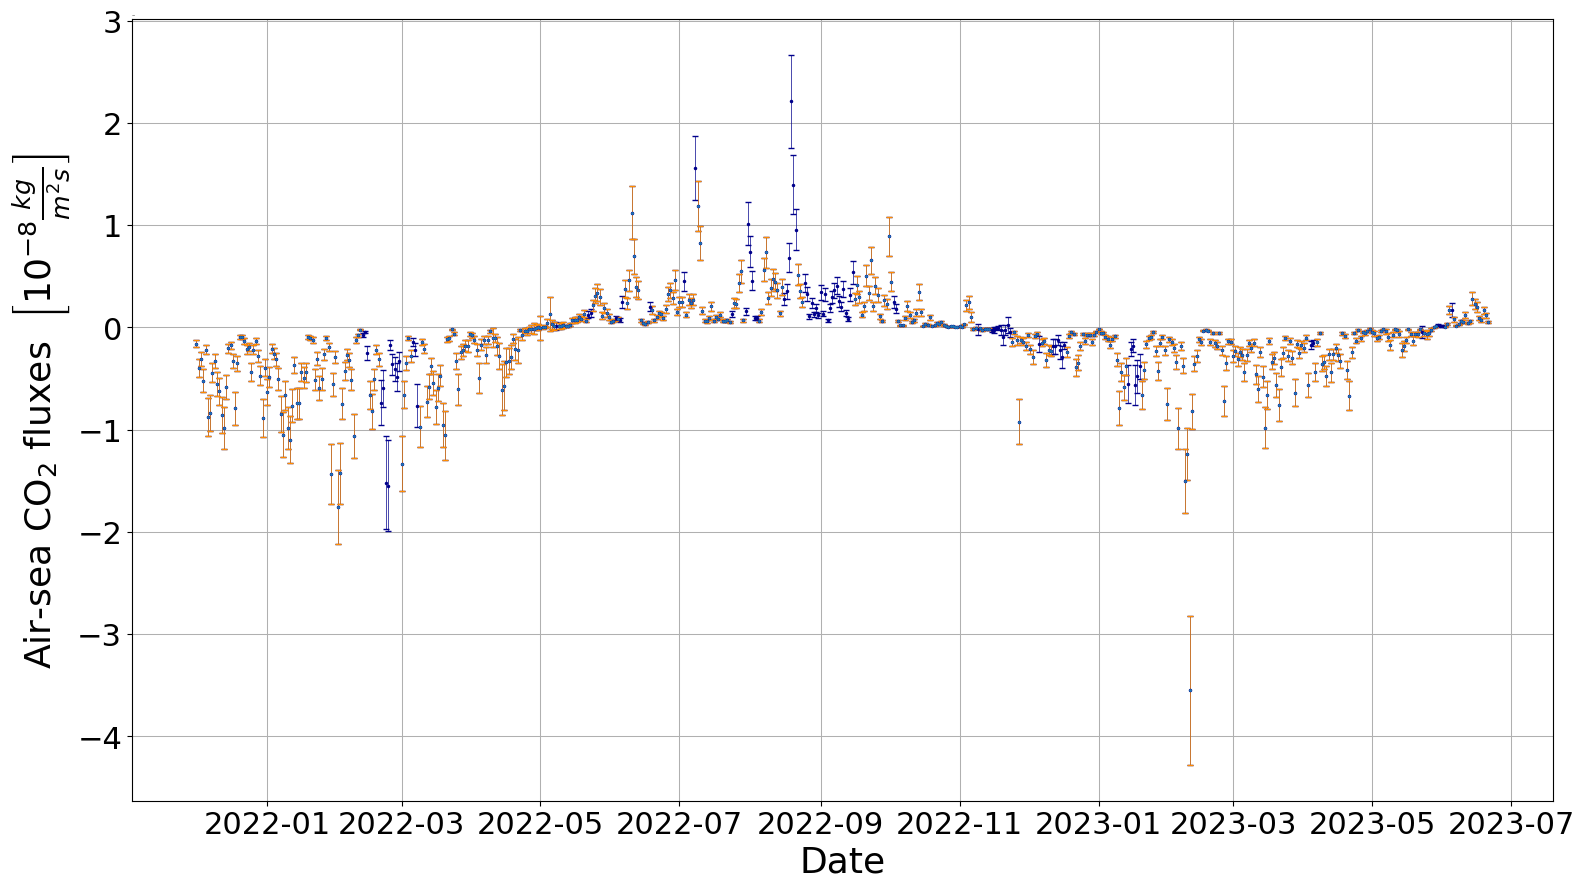

In [29]:
#plot together w different colours the interpolated and the non-interpolated fluxes


#save dates w wind above 8 m/s to show them differently in the plot
#per non cambiare il plot, e volendo togliere i trignaoloi rossi metto un valore ELEVATISSIMO
dates_wind_threshold = fluxes_data[fluxes_data.wind >= 8].date.values

plt.figure(figsize=(16, 9))
ax = plt.axes()



plt.errorbar(flux_df.date, flux_df["flux"], yerr=flux_df["flux_max_err"], fmt='o', color= "darkblue", markersize=1.5, capsize=2, ecolor = "darkblue", elinewidth=0.5, label = "Daily mean fluxes with interpolated data")
plt.errorbar(flux_df_nointerp.date, flux_df_nointerp["flux"], yerr=flux_df_nointerp["flux_max_err"], fmt="o", markersize=1, capsize=2, ecolor = "darkorange", elinewidth=0.5, label = "Daily mean fluxes")



#i want to plot the dates with wind above 8 m/s with a different marker
#i use where buil-in function to find the indexes of the dates with wind above 8 m/s



plt.plot(dates_wind_threshold, fluxes_data[fluxes_data.date.isin(dates_wind_threshold)].flux, '^', markersize = 6, color = "darkred", label = "Wind threshold")

plt.grid(lw = 0.75)

plt.xlabel("Date", fontsize = 30)
plt.ylabel(r"Air-sea CO$_2$ fluxes  $\left[ 10^{-8} \frac{kg}{m^2s} \right]$", fontsize = 30)

ax.yaxis.get_offset_text().set_fontsize(0)


plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.tight_layout()

#plt.savefig("../20230930_bihour_fluxes_werr.png", dpi = 300)


CUMULATIVE FLUXES
---

W MAXIMIZED ERRORS

In [13]:
#compute and plot the cumulative fluxes on three different time scales: the first year, Dec-may first year and dec-may second year


#w interpolation all the time series
cumul_fluxes_interp = pd.DataFrame({"date": flux_df.date, "flux": flux_df["flux(kg/sm2)_max"]})
cumul_fluxes_interp["flux_daily_integrated"] = cumul_fluxes_interp.apply(lambda x: x.flux*24*60*60, axis = 1)
cumul_fluxes_interp["cumul_flux"] = np.cumsum(cumul_fluxes_interp.flux_daily_integrated)

#separate nominal and error
cumul_fluxes_interp["cumul_flux_nominal"] = cumul_fluxes_interp.apply(lambda x: x.cumul_flux.nominal_value, axis = 1)
cumul_fluxes_interp["cumul_flux_err"] = cumul_fluxes_interp.apply(lambda x: x.cumul_flux.std_dev, axis = 1)

#from december (included) do may (excluded) of the first year 21-22 (absorption period)
dec_to_may_interp = cumul_fluxes_interp[cumul_fluxes_interp.date == dt.datetime(2022,5,1)].cumul_flux.values[0]

#from may 22 to dec 22 (emission period)
cumul_may22 = cumul_fluxes_interp[cumul_fluxes_interp.date >= dt.datetime(2022,5,1)][["date", "flux", "flux_daily_integrated"]]
cumul_may22["cumul_flux"] = np.cumsum(cumul_may22.flux_daily_integrated)

may_to_dec_interp = cumul_may22[cumul_may22.date == dt.datetime(2022,12,1)].cumul_flux.values[0]

#the first year 21-22 net effect (from 1 december 2021 to 30 november 2022)
first_year_interp = cumul_fluxes_interp[cumul_fluxes_interp.date == dt.datetime(2022,12,1)].cumul_flux.values[0]

#mhw effect; evaluate cumul flux dec 22 - may 23
cumul_dec_22 = cumul_fluxes_interp[cumul_fluxes_interp.date >= dt.datetime(2022,12,1)][["date", "flux", "flux_daily_integrated"]]
cumul_dec_22["cumul_flux"] = np.cumsum(cumul_dec_22.flux_daily_integrated)

dec_to_may_mhw_interp = cumul_dec_22[cumul_dec_22.date == dt.datetime(2023,5,1)].cumul_flux.values[0]



#w/o interpolation all the time series
cumul_fluxes_nointerp = pd.DataFrame({"date": flux_df_nointerp.dropna().date, "flux": flux_df_nointerp.dropna()["flux(kg/sm2)_max"]})
cumul_fluxes_nointerp["flux_daily_integrated"] = cumul_fluxes_nointerp.apply(lambda x: x.flux*24*60*60, axis = 1)
cumul_fluxes_nointerp["cumul_flux"] = np.cumsum(cumul_fluxes_nointerp.flux_daily_integrated)

#nan rising errors in cumsum, i drop and recalculate
#cumul_fluxes_nointerp.dropna(inplace = True)
#cumul_fluxes_nointerp.reset_index(drop=True, inplace=True)

cumul_fluxes_nointerp["cumul_flux"] = np.cumsum(cumul_fluxes_nointerp.flux_daily_integrated)



#separate nominal and error
cumul_fluxes_nointerp["cumul_flux_nominal"] = cumul_fluxes_nointerp.apply(lambda x: x.cumul_flux.nominal_value, axis = 1)
cumul_fluxes_nointerp["cumul_flux_err"] = cumul_fluxes_nointerp.apply(lambda x: x.cumul_flux.std_dev, axis = 1)

#from december (included) do may (excluded) of the first year 21-22 (absorption period)
dec_to_may_nointerp = cumul_fluxes_nointerp[cumul_fluxes_nointerp.date == dt.datetime(2022,5,1)].cumul_flux.values[0]

#from may 22 to dec 22 (emission period)
cumul_may22_nointerp = cumul_fluxes_nointerp[cumul_fluxes_nointerp.date >= dt.datetime(2022,5,1)][["date", "flux", "flux_daily_integrated"]]
cumul_may22_nointerp["cumul_flux"] = np.cumsum(cumul_may22_nointerp.flux_daily_integrated)

may_to_dec_nointerp = cumul_may22_nointerp[cumul_may22_nointerp.date == dt.datetime(2022,12,1)].cumul_flux.values[0]

#the first year 21-22 net effect (from 1 december 2021 to 30 november 2022)
first_year_nointerp = cumul_fluxes_nointerp[cumul_fluxes_nointerp.date == dt.datetime(2022,12,1)].cumul_flux.values[0]

#mhw effect; evaluate cumul flux dec 22 - may 23
cumul_dec_22_nointerp = cumul_fluxes_nointerp[cumul_fluxes_nointerp.date >= dt.datetime(2022,12,1)][["date", "flux", "flux_daily_integrated"]]
cumul_dec_22_nointerp["cumul_flux"] = np.cumsum(cumul_dec_22_nointerp.flux_daily_integrated)

dec_to_may_mhw_nointerp = cumul_dec_22_nointerp[cumul_dec_22_nointerp.date == dt.datetime(2023,5,1)].cumul_flux.values[0]


print("Cumulative fluxes interpolated")
print("Dec 21 - May 22 (ocean absorption)", dec_to_may_interp)
print("May 22 - Dec 22 (ocean emission)", may_to_dec_interp)
print("First year 21-22 net effect", first_year_interp)
print("Dec 22 - May 23 (MHW)", dec_to_may_mhw_interp)

print("mhw effect: mhw flux/ non mhw flux (%) = ", (dec_to_may_mhw_interp)/dec_to_may_interp*100)

print("\n\n")

print("Cumulative fluxes non-interpolated")
print("Dec 21 - May 22 (ocean absorption)", dec_to_may_nointerp)
print("May 22 - Dec 22 (ocean emission)", may_to_dec_nointerp)
print("First year 21-22 net effect", first_year_nointerp)
print("Dec 22 - May 23 (MHW)", dec_to_may_mhw_nointerp)

print("mhw effect: mhw flux/ non mhw flux (%) =", (dec_to_may_mhw_nointerp)/dec_to_may_nointerp*100)



Cumulative fluxes interpolated
Dec 21 - May 22 (ocean absorption) -0.0550+/-0.0014
May 22 - Dec 22 (ocean emission) 0.0378+/-0.0010
First year 21-22 net effect -0.0173+/-0.0017
Dec 22 - May 23 (MHW) -0.0382+/-0.0011
mhw effect: mhw flux/ non mhw flux (%) =  69.4+/-2.6



Cumulative fluxes non-interpolated
Dec 21 - May 22 (ocean absorption) -0.0484+/-0.0012
May 22 - Dec 22 (ocean emission) 0.0229+/-0.0007
First year 21-22 net effect -0.0255+/-0.0014
Dec 22 - May 23 (MHW) -0.0347+/-0.0010
mhw effect: mhw flux/ non mhw flux (%) = 71.6+/-2.7


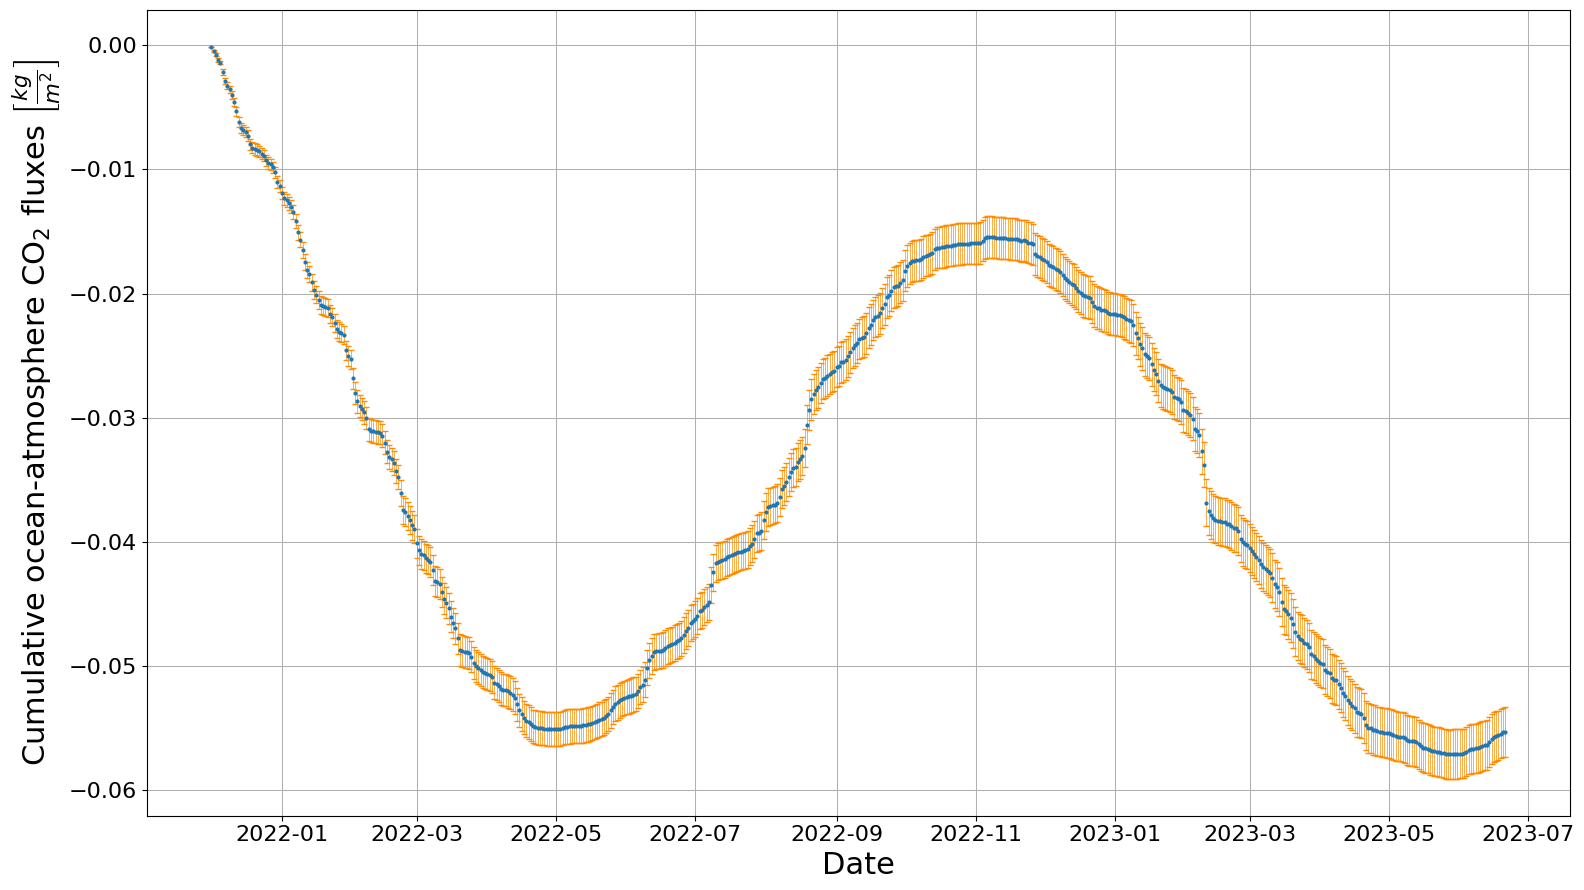

In [65]:
plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.errorbar(cumul_fluxes_interp.date, cumul_fluxes_interp.cumul_flux_nominal, yerr = cumul_fluxes_interp.cumul_flux_err, fmt='o', markersize=2, capsize=2, ecolor = "darkorange", elinewidth=0.5)
#plt.errorbar(cumul_fluxes_nointerp.date, cumul_fluxes_nointerp.cumul_flux_nominal, yerr = cumul_fluxes_nointerp.cumul_flux_err, fmt='o', color="darkgrey", markersize=2, capsize=2, ecolor = "darkorange", elinewidth=0.5)


plt.grid(lw = 0.75)

plt.xlabel("Date", fontsize = 22)
plt.ylabel(r"Cumulative ocean-atmosphere CO$_2$ fluxes $\left[\frac{kg}{m^2} \right]$", fontsize = 22)

ax.yaxis.get_offset_text().set_fontsize(0)

#plt.legend()

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.tight_layout()

#plt.savefig("../20230930_cumulative_fluxes.png", dpi = 300)

ARTICLE
---

conti e conversioni

In [22]:
#i have to compute air pco2 to plot the difference between the air and the sea pco2 for the article (i cant use the flux_df because there are gaps related to the ocean pco2)

err_pH2O = 0.00015

start_date = dt.datetime(2021,12,1)
end_date = dt.datetime(2023,6,30)

delta = dt.timedelta(days=1)

date_to_append = []
air_pco2 = []
air_pco2_nointerp = []
ph2o = []

while start_date <= end_date:

    #print(start_date)
    buoy = buoy_daily[((buoy_daily.date >= start_date) & (buoy_daily.date < start_date+delta))].reset_index()
    meteo = meteo_daily[((meteo_daily.date >= start_date) & (meteo_daily.date < start_date+delta))].reset_index()
    air = air_co2[((air_co2.date >= start_date) & (air_co2.date < start_date+delta))].reset_index()

    if len(buoy) > 0 and len(meteo) > 0 and len(air) > 0:

        #----------------------------------INTERPOLATI----------------------------------
        SST = buoy['interp_T'][0]
        SST_K = SST+273.15
        S = buoy["interp_S"][0]
        P = meteo["interp_P"][0]
        P_err = meteo["p_max_err"][0]
        xCO2_air = air["interp_xCO2"][0]
        xCO2_air_err = air["xCO2_max_err"][0]
        p_to_use = ufloat(P, P_err)
        xco2_to_use = ufloat(xCO2_air, xCO2_air_err)
        #CALCOLO SC PER ACQUA CON T IN CELSIUS
        Sc = schmidt_number(SST)
        #CALCOLO SOLUBILITÀ con T in K

        #mi calcolo la gas transfer velocity anche a parte (per il flusso la calcolo già nella funzione flux), ma mi serve per l'incertezza
        #print(K
        #CALCOLO PRESSIONE DI VAPORE SATURO
        pH2O = press_H2O(SST_K, S)
        pH2O_to_use = ufloat(pH2O, err_pH2O*pH2O)   
        #CALCOLO PRESS PARZ CO2 in ari
        pCO2_air = pCO2_func(xco2_to_use, p_to_use, pH2O_to_use)
        air_pco2.append(pCO2_air)
        date_to_append.append(start_date)
        ph2o.append(pH2O_to_use)


        #----------------------------------NON INTERPOLATI----------------------------------
        SST = buoy['temp'][0]
        SST_K = SST+273.15
        S = buoy["sal"][0]
        P = meteo["p"][0]
        P_err = meteo["p_max_err"][0]

        xCO2_air = air["xCO2"][0]
        xCO2_air_err = air["xCO2_max_err"][0]

        p_to_use = ufloat(P, P_err)
        xco2_to_use = ufloat(xCO2_air, xCO2_air_err)

        #CALCOLO PRESSIONE DI VAPORE SATURO
        pH2O = press_H2O(SST_K, S)

        pH2O_to_use = ufloat(pH2O, err_pH2O*pH2O)

        #CALCOLO PRESS PARZ CO2 in aria

        pCO2_air = pCO2_func(xco2_to_use, p_to_use, pH2O_to_use)

        air_pco2_nointerp.append(pCO2_air)



    
    start_date += delta

air_pco2 = pd.DataFrame({"date": date_to_append, "air_pco2_w_err": air_pco2, "air_pco2_nointerp_w_err": air_pco2_nointerp, "ph2o": ph2o})

air_pco2["air_pco2"] = air_pco2.apply(lambda x: x["air_pco2_w_err"].nominal_value, axis = 1)
air_pco2["air_pco2_max_err"] = air_pco2.apply(lambda x: x["air_pco2_w_err"].std_dev, axis = 1)
air_pco2["air_pco2_nointerp"] = air_pco2.apply(lambda x: x["air_pco2_nointerp_w_err"].nominal_value, axis = 1)
air_pco2["air_pco2_nointerp_max_err"] = air_pco2.apply(lambda x: x["air_pco2_nointerp_w_err"].std_dev, axis = 1)

In [9]:
fluxes_data["flux_nom"] = fluxes_data.apply(lambda x: x.flux.nominal_value, axis = 1)
fluxes_data["flux_err"] = fluxes_data.apply(lambda x: x.flux.std_dev, axis = 1)

fluxes_data["delta_pco2_nom"] = fluxes_data.apply(lambda x: x.delta_pco2.nominal_value, axis = 1) 
fluxes_data["delta_pco2_err"] = fluxes_data.apply(lambda x: x.delta_pco2.std_dev, axis = 1)


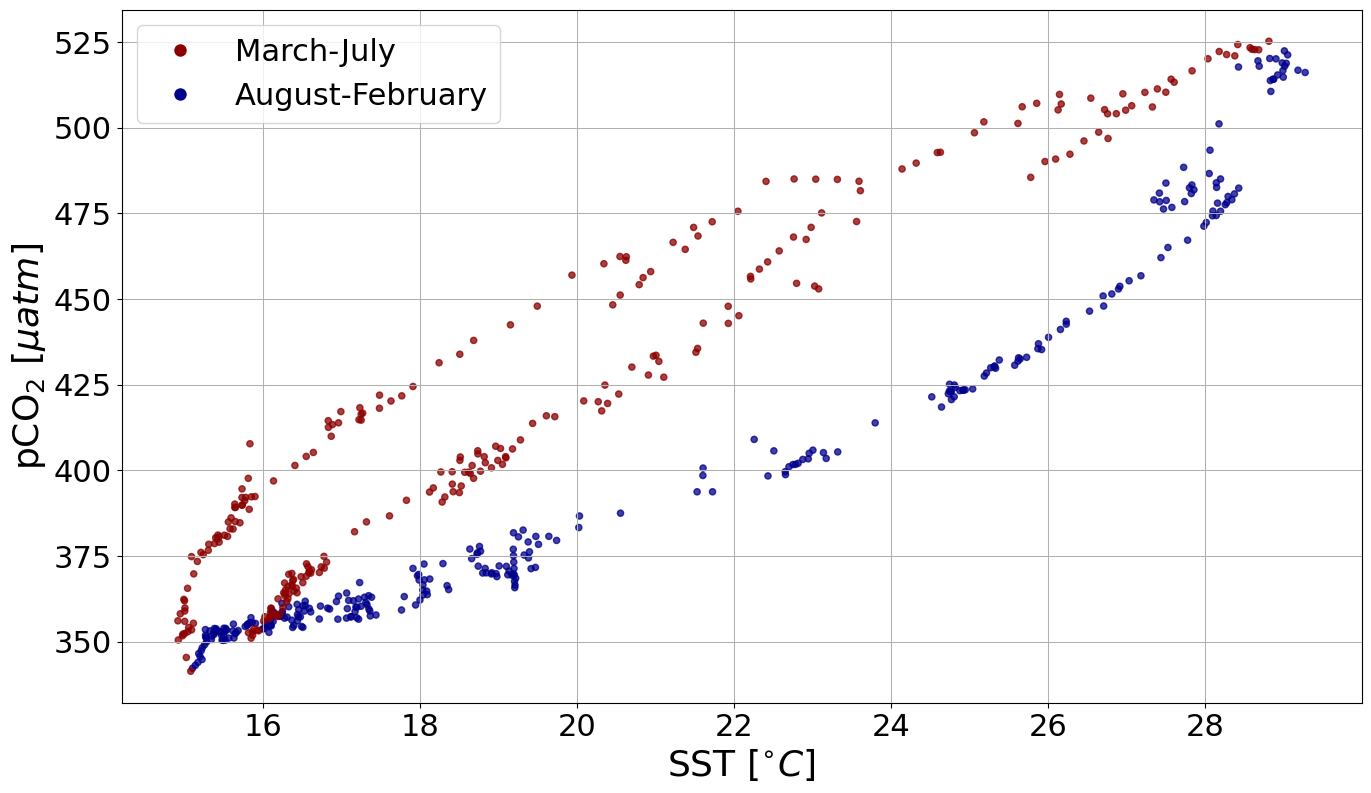

In [28]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(16,9))

color_scale = np.where(buoy_daily.date.dt.month.isin([3,4,5,6,7]), "darkred", "darkblue")

plt.scatter(buoy_daily["interp_T"], buoy_daily["interp_pco2"], c = color_scale, s = 20, alpha = 0.75)
#fig.colorbar(cb).set_label(label = "Date", fontsize = 18)
plt.grid(linewidth = 0.75)
plt.ylabel(r"pCO$_2$ $\left[ \mu atm \right]$", fontsize = 26)
plt.yticks(fontsize = 22)
plt.xlabel(r"SST $\left[ ^{\circ} C \right]$", fontsize = 26)
plt.xticks(fontsize = 22)

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=10, label='March-July'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=10, label='August-February')
]
plt.legend(handles=legend_elements, fontsize=22)


conta dei giorni sopra e sotto soglia

In [ ]:


# winds thresholds
lower_threshold = 5  # esempio
upper_threshold = 8  # esempio

#startinf from meteo_daily dataframe containing wind and pressure dailu data
wind_analysis = meteo_daily[['date', 'wind']].copy()

# select analysis period
period1 = wind_analysis[(wind_analysis['date'] >= '2021-12-01') & (wind_analysis['date'] < '2022-05-01')]
period2 = wind_analysis[(wind_analysis['date'] >= '2022-12-01') & (wind_analysis['date'] < '2023-05-01')]

# count days above and below the thresholds
def count_days_above_below_threshold(df, lower_threshold, upper_threshold):
    below = df[df['wind'] < lower_threshold].shape[0]
    above = df[df['wind'] > upper_threshold].shape[0]
    return below, above



# Analisi sui due periodi
below_p1, above_p1 = count_days_above_below_threshold(period1, lower_threshold, upper_threshold)
below_p2, above_p2 = count_days_above_below_threshold(period2, lower_threshold, upper_threshold)

print(f"Period 1 (Dec21-May22): Days below {lower_threshold} m/s: {below_p1}, Days above {upper_threshold} m/s: {above_p1}")
print(f"Period 2 (Dec22-May23): Days below {lower_threshold} m/s: {below_p2}, Days above {upper_threshold} m/s: {above_p2}")



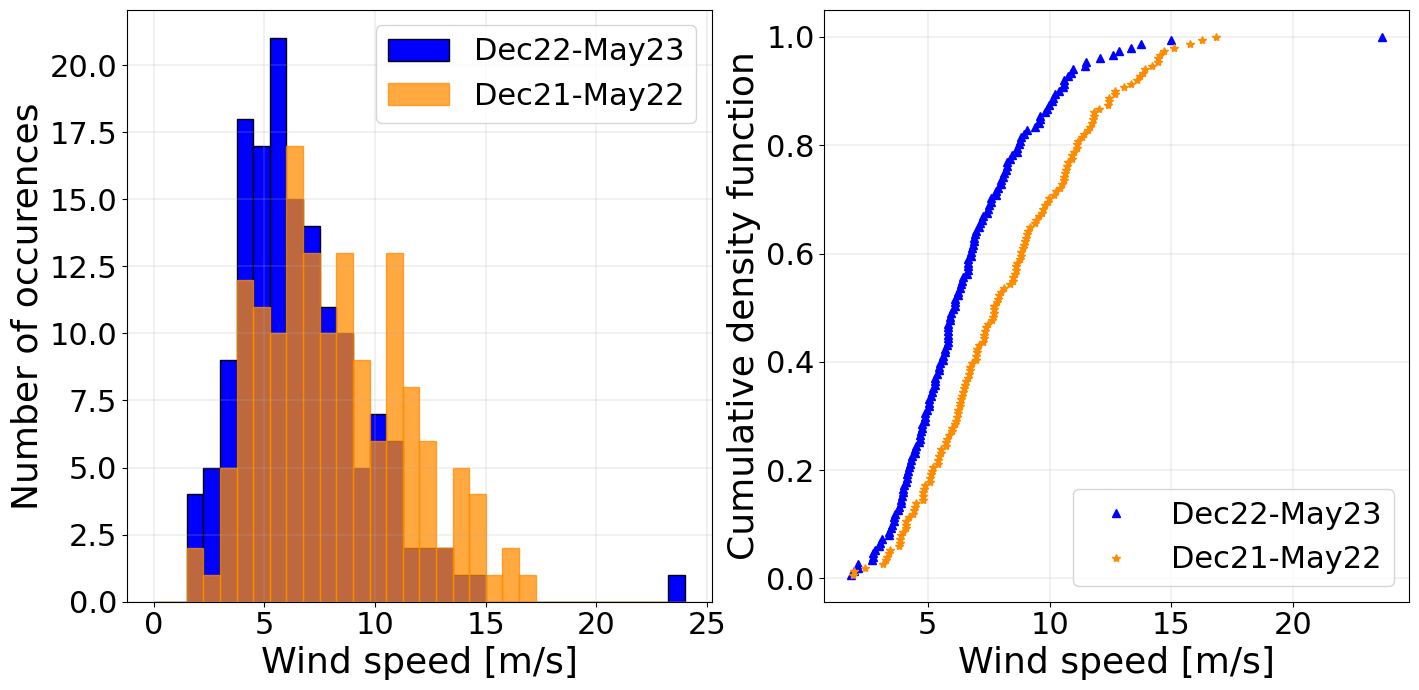

In [35]:


period_1 = wind_analysis[(wind_analysis['date'] >= '2021-12-01') & (wind_analysis['date'] < '2022-05-01')]
period_2 = wind_analysis[(wind_analysis['date'] >= '2022-12-01') & (wind_analysis['date'] < '2023-05-01')]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

bins = np.arange(0, max(max(period1["wind"]), max(period2["wind"])) + 0.75, 0.75)


ax1.hist(period_2['wind'], bins=bins, alpha=1, label='Dec22-May23', color='blue', edgecolor='black')
ax1.hist(period_1['wind'], bins=bins, alpha=.75, label='Dec21-May22', color='darkorange', edgecolor='darkorange')


ax1.set_xlabel('Wind speed [m/s]', fontsize = 26)
ax1.set_ylabel('Number of occurences', fontsize = 26)
ax1.tick_params(axis = "both", labelsize = 22)
ax1.legend(fontsize = 22)
ax1.grid(lw =.25)

sorted_wind_1 = np.sort(period_1['wind'])
cumulative_1 = np.arange(1, len(sorted_wind_1) + 1) / len(sorted_wind_1)


sorted_wind_2 = np.sort(period_2['wind'])
cumulative_2 = np.arange(1, len(sorted_wind_2) + 1) / len(sorted_wind_2)


ax2.plot(sorted_wind_2, cumulative_2, "^", label='Dec22-May23', color='blue')
ax2.plot(sorted_wind_1, cumulative_1, "*", label='Dec21-May22', color='darkorange')



ax2.set_xlabel('Wind speed [m/s]', fontsize = 26)
ax2.set_ylabel('Cumulative density function', fontsize = 26)
ax2.tick_params(axis = "both", labelsize = 22)
ax2.legend(fontsize = 22)
ax2.grid(lw = .25)


plt.tight_layout()
plt.show()


FIG 3

In [ ]:
interp_pco2 = buoy_daily[buoy_daily.pco2.isna() == True][["date", "interp_pco2"]]

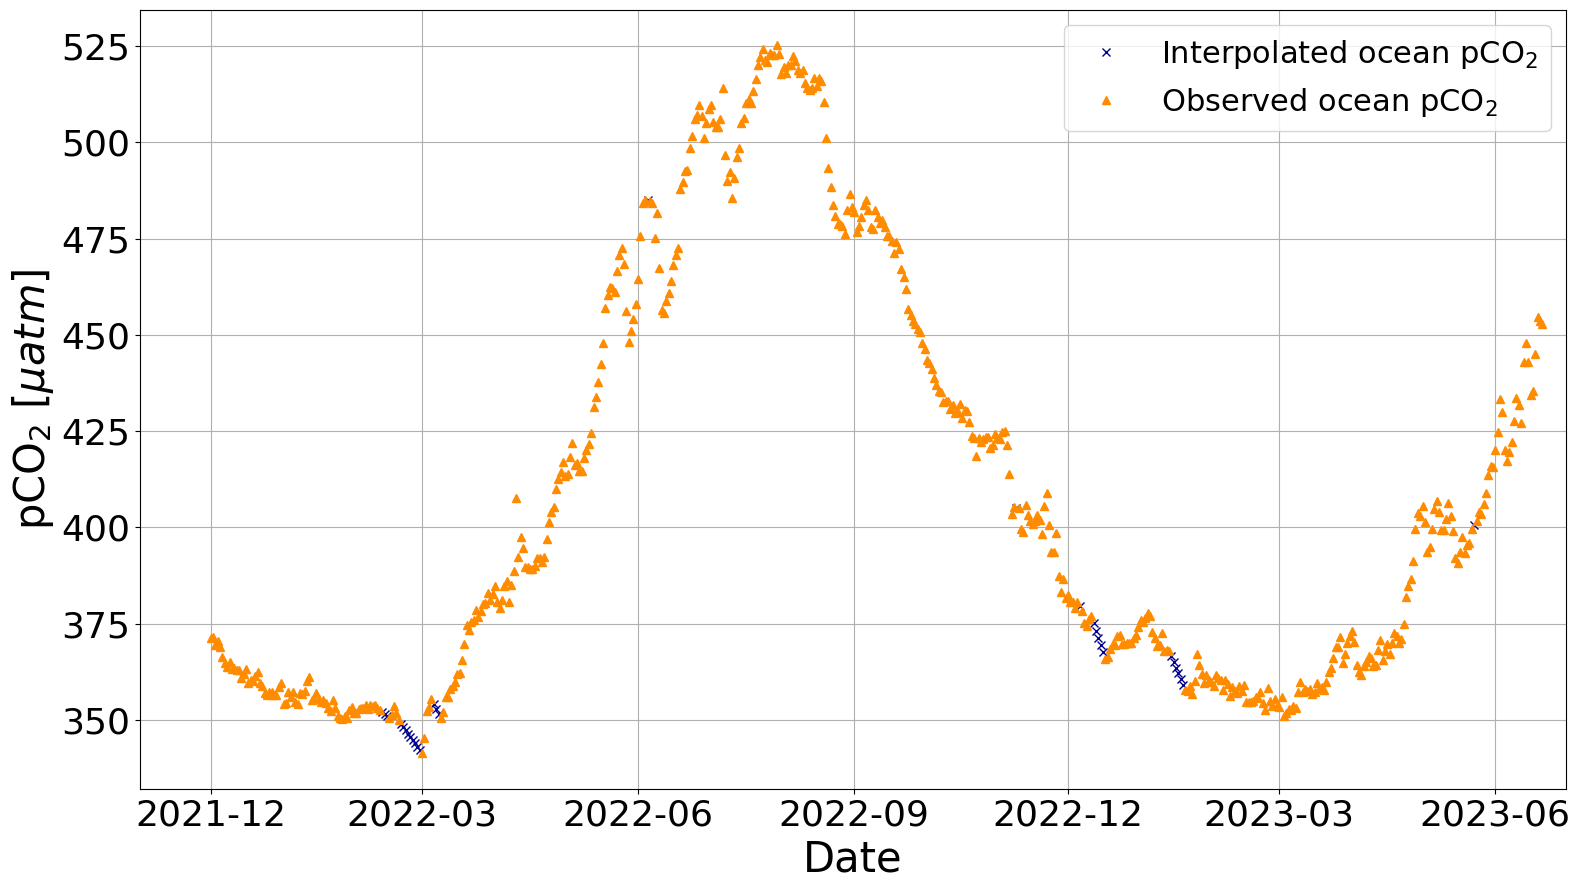

In [ ]:
#plot pco2 air and sea to have a reference

plt.figure(figsize=(16, 9))

ax = plt.axes()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))


ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax.set_xlim(dt.datetime(2021,11,1), dt.datetime(2023,7,1))


ax.plot(interp_pco2.date, interp_pco2.interp_pco2, 'x', color='darkblue', label=r'Interpolated ocean pCO$_2$')
ax.plot(buoy_daily.date, buoy_daily.pco2, marker = '^', lw = 0,color='darkorange', label=r'Observed ocean pCO$_2$')




#ax.set_title("5m depth hourly density")
ax.set_xlabel("Date", fontsize = 30)
ax.set_ylabel(r"pCO$_2$ $\left[ \mu atm \right]$", fontsize = 30)

ax.grid(axis= "x", which = "both")
ax.grid(axis = "y", which="major")
ax.tick_params(axis='both', which='both', labelsize=26)
ax.legend(fontsize = 22)
plt.tight_layout()

plt.savefig("./Figure3.jpg", format = "jpg")

Fig 6

In [ ]:
interp_T = buoy_daily[buoy_daily.temp.isna() == True][["date", "interp_T"]]
interp_S = buoy_daily[buoy_daily.sal.isna() == True][["date", "interp_S"]]

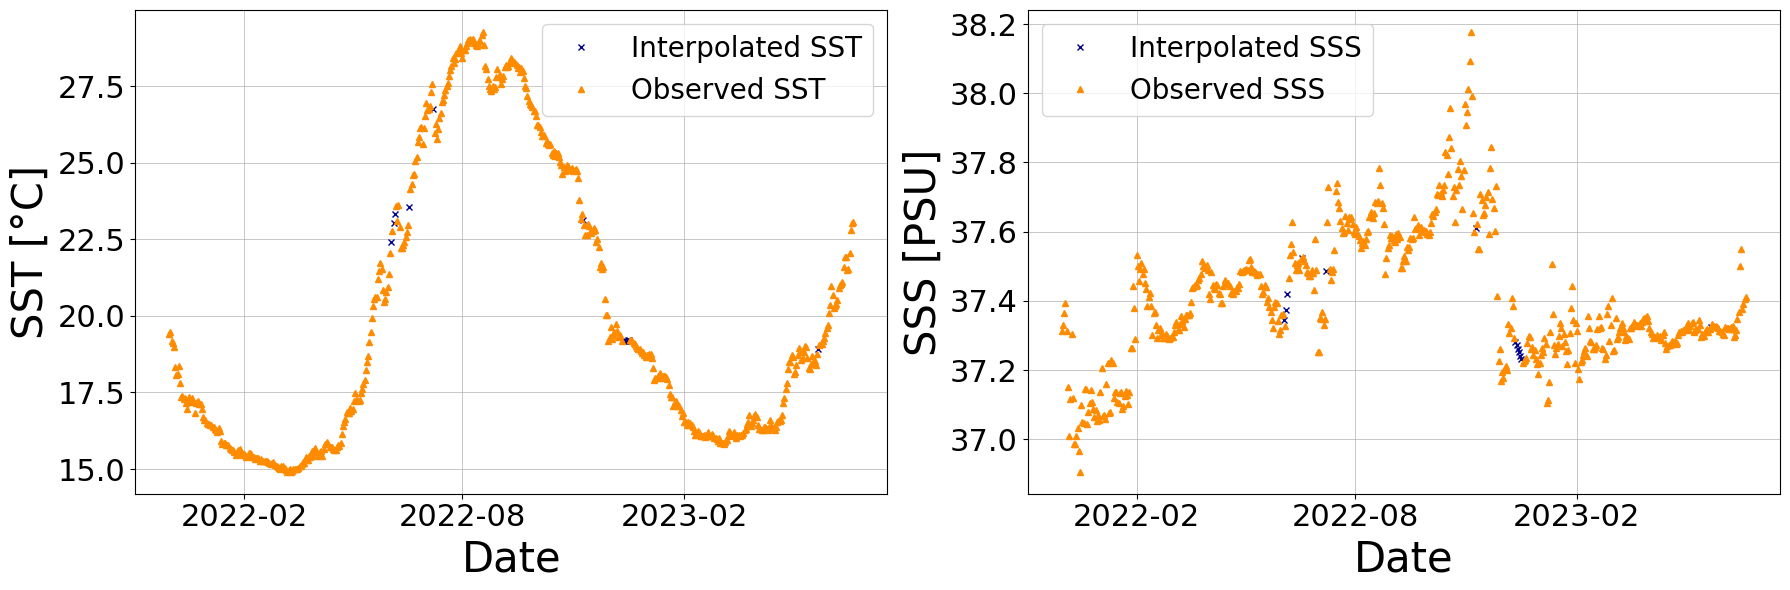

In [ ]:
#figura con l'evoluzione delle 4 grandezze principali nel tempo: sst, sss, pco2 oce a pco2 aria

fig, axs = plt.subplots(1,2, figsize = (18, 6))




#-----------------SST-----------------

ax0 = axs[0]

ax0.plot(interp_T.date, interp_T.interp_T, "x", markersize = 5, label = "Interpolated SST", color = "darkblue")
ax0.plot(buoy_daily.date, buoy_daily.temp, "^", markersize = 5, label = "Observed SST", color = "darkorange")


ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

ax0.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

ax0.set_ylabel("SST [°C]", fontsize = 30)
ax0.set_xlabel("Date", fontsize = 30)


ax0.tick_params(axis='both', which='both', labelsize=22)
ax0.tick_params(axis = "x")

ax0.legend(fontsize = 20)

ax0.grid(lw = .5)

#-----------------SSS-----------------

ax1 = axs[1]

ax1.plot(interp_S.date, interp_S.interp_S, "x", markersize = 5, label = "Interpolated SSS", color = "darkblue")
ax1.plot(buoy_daily.date, buoy_daily.sal, "^", markersize = 5, label = "Observed SSS", color = "darkorange")

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))


ax1.set_ylabel("SSS [PSU]", fontsize = 30)
ax1.set_xlabel("Date", fontsize = 30)

ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.tick_params(axis = "x", rotation = 0)


ax1.legend(fontsize = 20)

ax1.grid(lw = .5)



plt.tight_layout()

plt.savefig("Figure6.jpg", format = "jpg")




Fig 7

In [ ]:
interp_pco2 = buoy_daily[buoy_daily.pco2.isna() == True][["date", "interp_pco2", "pco2_max_err"]]
interp_air_pco2 = air_pco2[air_pco2.air_pco2_nointerp.isna() == True][["date", "air_pco2", "air_pco2_max_err"]]

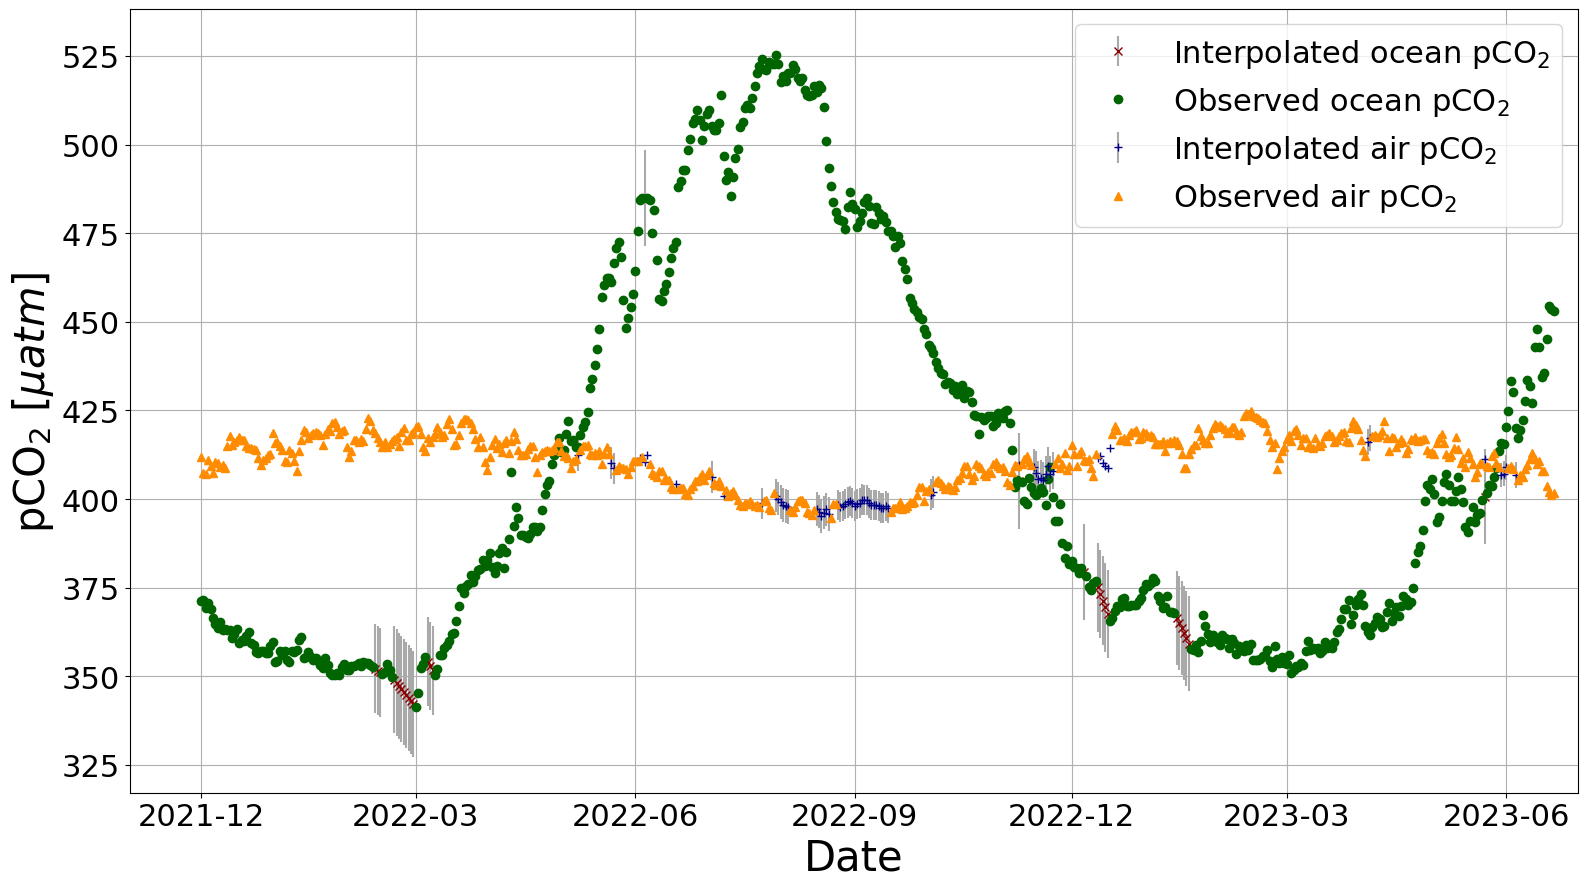

In [ ]:
#plot pco2 air and sea to have a reference

plt.figure(figsize=(16, 9))

ax = plt.axes()

ax.set_xlim(dt.datetime(2021,11,1), dt.datetime(2023,7,1))


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))


ax.errorbar(interp_pco2.date, interp_pco2.interp_pco2, yerr=interp_pco2.pco2_max_err, fmt='x', markersize = 6, color='darkred', ecolor = "darkgrey", label=r'Interpolated ocean pCO$_2$')
ax.errorbar(buoy_daily.date, buoy_daily.pco2, yerr = buoy_daily.pco2_max_err, marker = 'o', lw = 0, markersize = 6,  color='darkgreen', ecolor = "darkgrey", label=r'Observed ocean pCO$_2$')


ax.errorbar(interp_air_pco2.date, interp_air_pco2.air_pco2, yerr = interp_air_pco2.air_pco2_max_err, fmt='+', markersize = 6, color='darkblue', ecolor = "darkgrey", label=r'Interpolated air pCO$_2$')
ax.errorbar(air_pco2.date, air_pco2.air_pco2_nointerp, yerr = air_pco2.air_pco2_nointerp_max_err, marker = "^", lw = 0,markersize =6, color='darkorange', ecolor = "darkgrey", label=r'Observed air pCO$_2$')



#ax.set_title("5m depth hourly density")
ax.set_xlabel("Date", fontsize = 30)
ax.set_ylabel(r"pCO$_2$ $\left[ \mu atm \right]$", fontsize = 30)

ax.grid(axis= "x", which = "both")
ax.grid(axis = "y", which="major")
ax.tick_params(axis='both', which='both', labelsize=22)
ax.legend(fontsize = 22)
plt.tight_layout()

plt.savefig("./Figure7.jpg", format = "jpg")

fig 11

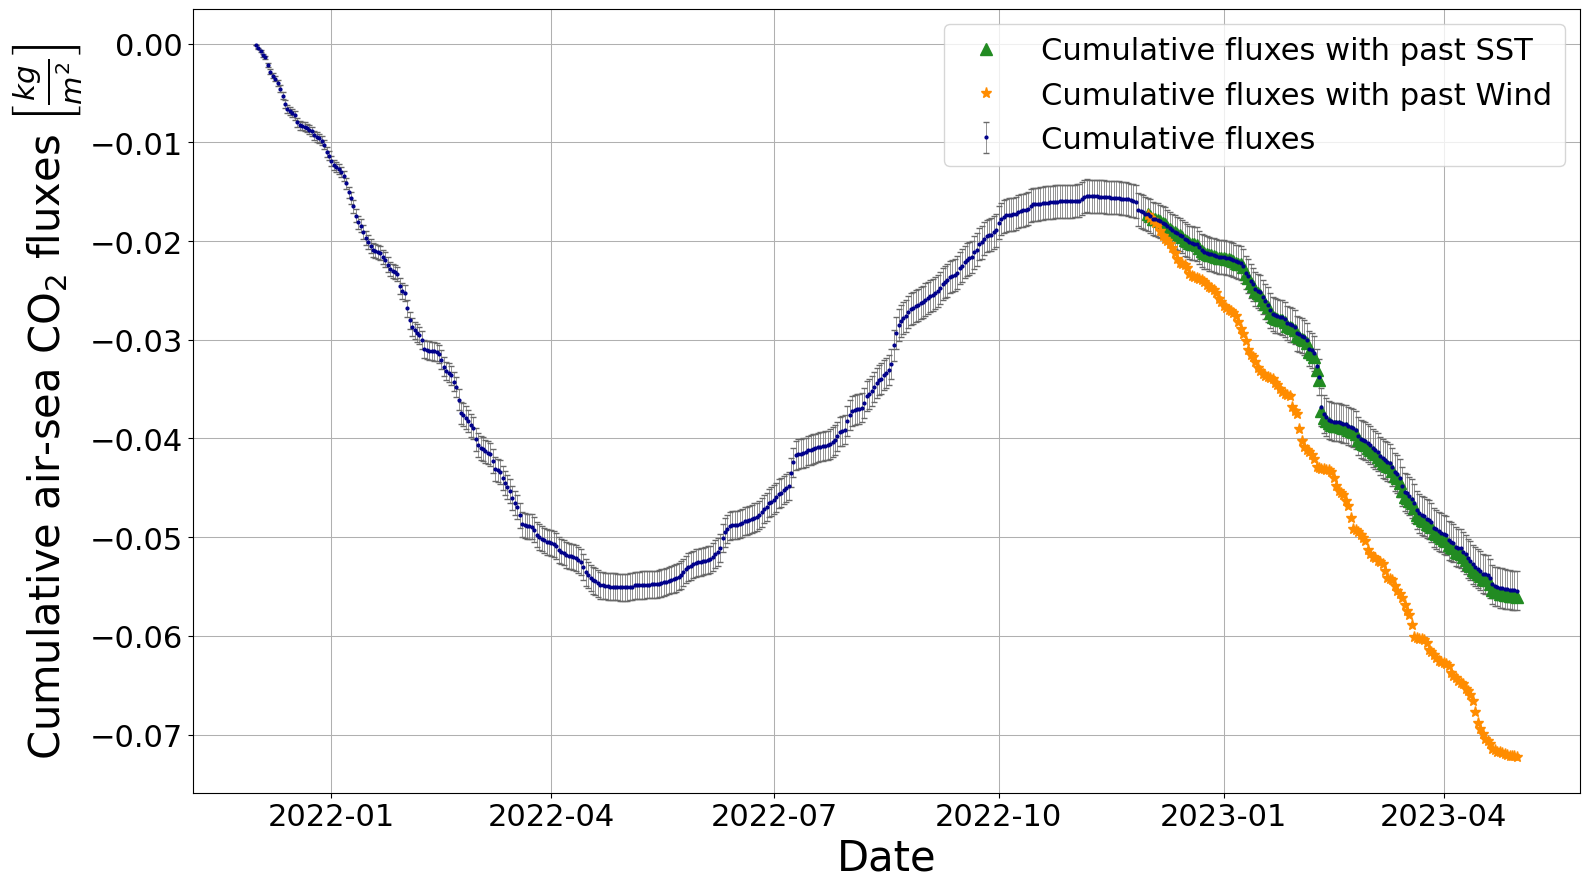

In [ ]:
plt.figure(figsize=(16, 9))
ax = plt.axes()

#plt.errorbar(cumul_fluxes_interp.date, cumul_fluxes_interp.cumul_flux_nominal, yerr = cumul_fluxes_interp.cumul_flux_err, fmt='o', color = "darkblue" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5,  label = "Cumulative fluxes")
plt.errorbar(flussi_cumulati.date, flussi_cumulati.cumul_true, yerr = flussi_cumulati["cumul_true_err"], fmt='o', color = "darkblue" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5,  label = "Cumulative fluxes")



flussi_cumulati_past_var = flussi_cumulati[flussi_cumulati["date"] >= dt.datetime(2022,12,1)]

plt.plot(flussi_cumulati_past_var.date, flussi_cumulati_past_var.cumul_sst, '^', color="forestgreen", markersize=8, label="Cumulative fluxes with past SST")
plt.plot(flussi_cumulati_past_var.date, flussi_cumulati_past_var.cumul_wind, '*', color="darkorange", markersize=8, label="Cumulative fluxes with past Wind")


plt.grid(lw = 0.75)

plt.xlabel("Date", fontsize = 30)
plt.ylabel(r"Cumulative air-sea CO$_2$ fluxes $\left[\frac{kg}{m^2} \right]$", fontsize = 30)

ax.yaxis.get_offset_text().set_fontsize(10)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))


#plt.legend()

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)
plt.tight_layout()

plt.savefig("./Figure11.jpg", format = "jpg")

FLUXES W PAST YEAR SST & WIND
---

build the dataframe w exchanged quantities

In [36]:

df_w_past_temperature = pd.DataFrame({"date":[], "SST": [], "S": [], "pco2": [], "pco2_err": [], "P": [], "P_err": [], "xco2": [], "xco2_err": [], "U2": []})

df_w_past_wind = pd.DataFrame({"date": [], "SST": [], "S": [], "pco2": [], "pco2_err": [], "P": [], "P_err": [], "xco2": [], "xco2_err": [], "U2": []})

#to append to the dataframes
count = 0

start_date = dt.datetime(2022,12,1)
end_date = dt.datetime(2023,5,1)
delta = dt.timedelta(days = 1)

for date_index in pd.date_range(start_date, end_date, freq = "D"):
    #print(date_index)

    #past variable
    past_year_date = dt.datetime(date_index.year -1, date_index.month, date_index.day)


    buoy = buoy_daily[((buoy_daily["date"] >= date_index) & (buoy_daily["date"] < date_index+delta))].reset_index()
    buoy_past = buoy_daily[((buoy_daily["date"] >= past_year_date) & (buoy_daily["date"] < past_year_date+delta))].reset_index()
    meteo = meteo_daily[((meteo_daily["date"] >= date_index) & (meteo_daily["date"] < date_index+delta))].reset_index()
    meteo_past =  meteo_daily[((meteo_daily["date"] >= past_year_date) & (meteo_daily["date"] < past_year_date+delta))].reset_index()
    air_df = air_co2[((air_co2["date"] >= date_index) & (air_co2["date"] < date_index+delta))].reset_index()

    if len(buoy) != 0 and len(buoy_past) != 0 and len(meteo) != 0 and len(meteo_past) != 0 and len(air_df) != 0:

        pco2 = buoy["interp_pco2"][0]
        pco2_err = buoy["pco2_max_err"][0]
        S = buoy["interp_S"][0]

        P = meteo["interp_P"][0]
        P_err = meteo["p_max_err"][0]    

        SST =  buoy["interp_T"][0]

        u2 = meteo["u2"][0] 


        xco2 = air_df["interp_xCO2"][0]
        xco2_err = air_df["xCO2_max_err"][0]


        

        #SST
        SST_past = buoy_past["interp_T"][0]

        #wind
        u2_past =meteo_past["u2"][0] 

        #build the dataframes

        df_w_past_temperature.loc[count] = [date_index, SST_past, S, pco2, pco2_err, P, P_err, xco2, xco2_err, u2]
        df_w_past_wind.loc[count] = [date_index, SST, S, pco2, pco2_err, P, P_err, xco2, xco2_err, u2_past]

        count += 1




In [ ]:
#i try to be smarter in the flux computation, wrt the previous version


#---------------------------------------------------------------------------------PAST TEMPERATURE------------------------

#computed with pco2 and P and xco2 max err


#wanninkhof 2014            
err_K = 0.2

#la solubilità ha 0.2% (WEISS 1974)
err_KH = 0.002


#pH20 ha un errore dello 0.015% (WEISS AND PRICE 1970)
err_pH2O = 0.00015



#mi definisco gli array delle grandezze con gli errori

flux_err = []
date_to_append = []
air_pco2 = []
solubility = []
gas_velocity = []

start_date = dt.datetime(2022,12,1)
end_date = dt.datetime(2023,5,1)

delta = dt.timedelta(days=1)



while start_date <= end_date:

    print(start_date)
    df = df_w_past_temperature[((df_w_past_temperature.date >= start_date) & (df_w_past_temperature.date < start_date+delta))].reset_index()

    if len(df) > 0:
    
        #i have to extract the variables and convert to ufloat to compute the fluxes
        SST = df['SST'][0]
        SST_K = SST+273.15
        S = df["S"][0]
        pCO2 = df["pco2"][0]
        pCO2_err = df["pco2_err"][0]

        pco2_to_use = ufloat(pCO2, pCO2_err)

        P = df["P"][0]
        P_err = df["P_err"][0]

        xCO2_air = df["xco2"][0]
        xCO2_air_err = df["xco2_err"][0]

        U2 = df["U2"][0]

        p_to_use = ufloat(P, P_err)
        xco2_to_use = ufloat(xCO2_air, xCO2_air_err)

        #CALCOLO SC PER ACQUA CON T IN CELSIUS
        Sc = schmidt_number(SST)

        #CALCOLO SOLUBILITÀ con T in K
        K0 = sol(SST_K, S)
        

        #mi calcolo la gas transfer velocity anche a parte (per il flusso la calcolo già nella funzione flux), ma mi serve per l'incertezza
        K = gas_transfer_velocity(U2, Sc)
        #print(K)

        #CALCOLO PRESSIONE DI VAPORE SATURO
        pH2O = press_H2O(SST_K, S)

        pH2O_to_use = ufloat(pH2O, err_pH2O*pH2O)

        #CALCOLO PRESS PARZ CO2 in aria

        pCO2_air = pCO2_func(xco2_to_use, p_to_use, pH2O_to_use)
        air_pco2.append(pCO2_air)
        solubility.append(K0)
        gas_velocity.append(K)

        #percentuali
        K_err = ufloat(K, err_K*K)
        K0_err = ufloat(K0, err_KH*K0)

        #compute air pressure (which is already a ufloat variable)
        #pa = pCO2(xco2_to_use, p_to_use, pH2O_to_use)

        #questo in cm/h * mol/(L*atm) * uatm
        flux = fluxes_K(pco2_to_use, pCO2_air, K0_err, K_err)
        flux_err.append(flux)
        date_to_append.append(start_date)

    else:
        print("missing data", start_date)
        

    start_date += delta

flux_w_past_temperature = pd.DataFrame({"date": date_to_append, "flux(cm/h*mol/(L*atm)*uatm)": flux_err})

flux_w_past_temperature["flux(kg/sm2)"] = flux_w_past_temperature.apply(lambda x: convert_flux(x["flux(cm/h*mol/(L*atm)*uatm)"]), axis = 1)

flux_w_past_temperature["air_pco2"] = air_pco2
flux_w_past_temperature["sol_w_err"] = K0_err
flux_w_past_temperature["k_w_err"] = K_err

flux_w_past_temperature["sol"] = flux_w_past_temperature.apply(lambda x: x["sol_w_err"].n, axis=1)
flux_w_past_temperature["sol_err"] = flux_w_past_temperature.apply(lambda x: x["sol_w_err"].s, axis=1)

flux_w_past_temperature["k"] = flux_w_past_temperature.apply(lambda x: x["k_w_err"].n, axis=1)
flux_w_past_temperature["k_err"] = flux_w_past_temperature.apply(lambda x: x["k_w_err"].s, axis=1)


In [ ]:
#i try to be smarter in the flux computation, wrt the previous version


#---------------------------------------------------------------------------------PAST WIND------------------------

#computed with pco2 and P and xco2 max err


#wanninkhof 2014            
err_K = 0.2

#la solubilità ha 0.2% (WEISS 1974)
err_KH = 0.002


#pH20 ha un errore dello 0.015% (WEISS AND PRICE 1970)
err_pH2O = 0.00015



#mi definisco gli array delle grandezze con gli errori

flux_err = []
date_to_append = []
air_pco2 = []
solubility = []
gas_velocity = []

start_date = dt.datetime(2022,12,1)
end_date = dt.datetime(2023,5,1)

delta = dt.timedelta(days=1)



while start_date <= end_date:

    print(start_date)
    df = df_w_past_wind[((df_w_past_wind.date >= start_date) & (df_w_past_wind.date < start_date+delta))].reset_index()

    if len(df) > 0:
    
        #i have to extract the variables and convert to ufloat to compute the fluxes
        SST = df['SST'][0]
        SST_K = SST+273.15
        S = df["S"][0]
        pCO2 = df["pco2"][0]
        pCO2_err = df["pco2_err"][0]

        pco2_to_use = ufloat(pCO2, pCO2_err)

        P = df["P"][0]
        P_err = df["P_err"][0]

        xCO2_air = df["xco2"][0]
        xCO2_air_err = df["xco2_err"][0]

        U2 = df["U2"][0]

        p_to_use = ufloat(P, P_err)
        xco2_to_use = ufloat(xCO2_air, xCO2_air_err)

        #CALCOLO SC PER ACQUA CON T IN CELSIUS
        Sc = schmidt_number(SST)

        #CALCOLO SOLUBILITÀ con T in K
        K0 = sol(SST_K, S)
        

        #mi calcolo la gas transfer velocity anche a parte (per il flusso la calcolo già nella funzione flux), ma mi serve per l'incertezza
        K = gas_transfer_velocity(U2, Sc)
        #print(K)

        #CALCOLO PRESSIONE DI VAPORE SATURO
        pH2O = press_H2O(SST_K, S)

        pH2O_to_use = ufloat(pH2O, err_pH2O*pH2O)

        #CALCOLO PRESS PARZ CO2 in aria

        pCO2_air = pCO2_func(xco2_to_use, p_to_use, pH2O_to_use)
        air_pco2.append(pCO2_air)
        solubility.append(K0)
        gas_velocity.append(K)

        #percentuali
        K_err = ufloat(K, err_K*K)
        K0_err = ufloat(K0, err_KH*K0)

        #compute air pressure (which is already a ufloat variable)
        #pa = pCO2(xco2_to_use, p_to_use, pH2O_to_use)

        #questo in cm/h * mol/(L*atm) * uatm
        flux = fluxes_K(pco2_to_use, pCO2_air, K0_err, K_err)
        flux_err.append(flux)
        date_to_append.append(start_date)

    else:
        print("missing data", start_date)
        

    start_date += delta

flux_w_past_wind = pd.DataFrame({"date": date_to_append, "flux(cm/h*mol/(L*atm)*uatm)": flux_err})

flux_w_past_wind["flux(kg/sm2)"] = flux_w_past_wind.apply(lambda x: convert_flux(x["flux(cm/h*mol/(L*atm)*uatm)"]), axis = 1)

flux_w_past_wind["air_pco2"] = air_pco2
flux_w_past_wind["sol_w_err"] = K0_err
flux_w_past_wind["k_w_err"] = K_err

flux_w_past_wind["sol"] = flux_w_past_wind.apply(lambda x: x["sol_w_err"].n, axis=1)
flux_w_past_wind["sol_err"] = flux_w_past_wind.apply(lambda x: x["sol_w_err"].s, axis=1)

flux_w_past_wind["k"] = flux_w_past_wind.apply(lambda x: x["k_w_err"].n, axis=1)
flux_w_past_wind["k_err"] = flux_w_past_wind.apply(lambda x: x["k_w_err"].s, axis=1)


In [40]:
flux_df_true = flux_df[((flux_df.date >= dt.datetime(2022,12,1)) & (flux_df.date <= dt.datetime(2023,5,1)))].reset_index()
flux_df_true_nointerp = flux_df_nointerp[((flux_df_nointerp.date >= dt.datetime(2022,12,1)) & (flux_df_nointerp.date <= dt.datetime(2023,5,1)))].reset_index()



flux_w_past_temperature["flux"] = flux_w_past_temperature.apply(lambda x: x["flux(kg/sm2)"].n, axis = 1)
flux_w_past_temperature["flux_err"] = flux_w_past_temperature.apply(lambda x: x["flux(kg/sm2)"].s, axis = 1)

flux_w_past_wind["flux"] = flux_w_past_wind.apply(lambda x: x["flux(kg/sm2)"].n, axis = 1)
flux_w_past_wind["flux_err"] = flux_w_past_wind.apply(lambda x: x["flux(kg/sm2)"].s, axis = 1)


cumulata

In [ ]:
#compute and plot the cumulative fluxes on three different time scales: the first year, Dec-may first year and dec-may second year


#w past sst
cumul_fluxes_w_past_sst = pd.DataFrame({"date": flux_w_past_temperature.date, "flux": flux_w_past_temperature["flux(kg/sm2)"]})
cumul_fluxes_w_past_sst["flux_daily_integrated"] = cumul_fluxes_w_past_sst.apply(lambda x: x.flux*24*60*60, axis = 1)
cumul_fluxes_w_past_sst["cumul_flux"] = np.cumsum(cumul_fluxes_w_past_sst.flux_daily_integrated)

#separate nominal and error
cumul_fluxes_w_past_sst["cumul_flux_nominal"] = cumul_fluxes_w_past_sst.apply(lambda x: x.cumul_flux.nominal_value, axis = 1)
cumul_fluxes_w_past_sst["cumul_flux_err"] = cumul_fluxes_w_past_sst.apply(lambda x: x.cumul_flux.std_dev, axis = 1)

#from december (included) do may (excluded) of the first year 21-22 (absorption period)
past_sst_cumul_value = cumul_fluxes_w_past_sst[cumul_fluxes_w_past_sst.date == dt.datetime(2023,5,1)].cumul_flux.values[0]


#w past wind
cumul_fluxes_w_past_wind = pd.DataFrame({"date": flux_w_past_wind.date, "flux": flux_w_past_wind["flux(kg/sm2)"]})
cumul_fluxes_w_past_wind["flux_daily_integrated"] = cumul_fluxes_w_past_wind.apply(lambda x: x.flux*24*60*60, axis = 1)
cumul_fluxes_w_past_wind["cumul_flux"] = np.cumsum(cumul_fluxes_w_past_wind.flux_daily_integrated)

#separate nominal and error
cumul_fluxes_w_past_wind["cumul_flux_nominal"] = cumul_fluxes_w_past_wind.apply(lambda x: x.cumul_flux.nominal_value, axis = 1)
cumul_fluxes_w_past_wind["cumul_flux_err"] = cumul_fluxes_w_past_wind.apply(lambda x: x.cumul_flux.std_dev, axis = 1)

#from december (included) do may (excluded) of the first year 21-22 (absorption period)
past_wind_cumul_value = cumul_fluxes_w_past_wind[cumul_fluxes_w_past_wind.date == dt.datetime(2023,5,1)].cumul_flux.values[0]







print("Cumulative fluxes w past values")
print("Dec 22 - May 23 (ocean absorption) 'observed values'", dec_to_may_mhw_interp)
print("Dec 22 - May 23 (ocean absorption) 'past sst'", past_sst_cumul_value)
print("Dec 22 - May 23 (ocean absorption) 'past wind'", past_wind_cumul_value)


#print("mhw effect: mhw flux/ non mhw flux (%) = ", (dec_to_may_mhw_interp)/dec_to_may_interp*100)

print("\n\n")



In [47]:
#per il plot faccio la cumulata usando il dataset vero nel 2021-22 così da aavere il plot ocn le linee che si separano a dec22

#faccio un unico dataframe con tutti i flussi (originale) e con SST/wind variate

flussi_cumulati = pd.DataFrame({"date": flux_df["date"], 
                                "flux_true_w_err": flux_df["flux(kg/sm2)_max"]})

flussi_cumulati["flux_sst_w_err"] = flux_df["flux(kg/sm2)_max"]
flussi_cumulati["flux_wind_w_err"] = flux_df["flux(kg/sm2)_max"]


for date_index in flussi_cumulati.date.values:
    if date_index in flux_w_past_temperature.date.values and date_index in flux_w_past_wind.date.values:
        #print(date_index)

        flussi_cumulati.loc[flussi_cumulati["date"] == date_index, "flux_sst_w_err"] = flux_w_past_temperature[flux_w_past_temperature["date"] ==  date_index]["flux(kg/sm2)"].values[0]
        flussi_cumulati.loc[flussi_cumulati["date"] == date_index, "flux_wind_w_err"] = flux_w_past_wind[flux_w_past_wind["date"] ==  date_index]["flux(kg/sm2)"].values[0]



#faccio colonne nominal and standard per i flussi
        
#flussi_cumulati["flux_true"] = flussi_cumulati.apply(lambda x: x["flux_true_w_err"].n, axis = 1)
#flussi_cumulati["flux_true_err"] = flussi_cumulati.apply(lambda x: x["flux_true_w_err"].s, axis = 1)

#flussi_cumulati["flux_sst"] = flussi_cumulati.apply(lambda x: x["flux_sst_w_err"].n, axis = 1)
#flussi_cumulati["flux_sst_err"] = flussi_cumulati.apply(lambda x: x["flux_sst_w_err"].s, axis = 1)

#flussi_cumulati["flux_wind"] = flussi_cumulati.apply(lambda x: x["flux_wind_w_err"].n, axis = 1)
#flussi_cumulati["flux_wind_err"] = flussi_cumulati.apply(lambda x: x["flux_wind_w_err"].s, axis = 1)

In [48]:
#compute the cumulative

#i drop values after 01 may 2023, which are outside the period of interest

flussi_cumulati = flussi_cumulati[flussi_cumulati["date"] <= dt.datetime(2023,5,1)]

#observed
flussi_cumulati["daily_true_integrated"] = flussi_cumulati.apply(lambda x: x["flux_true_w_err"]*24*60*60, axis = 1)
flussi_cumulati["cumul_true_w_err"] = np.cumsum(flussi_cumulati.daily_true_integrated)


#sst
flussi_cumulati["daily_sst_integrated"] = flussi_cumulati.apply(lambda x: x["flux_sst_w_err"]*24*60*60, axis = 1)
flussi_cumulati["cumul_sst_w_err"] = np.cumsum(flussi_cumulati.daily_sst_integrated)

#wind
flussi_cumulati["daily_wind_integrated"] = flussi_cumulati.apply(lambda x: x["flux_wind_w_err"]*24*60*60, axis = 1)
flussi_cumulati["cumul_wind_w_err"] = np.cumsum(flussi_cumulati.daily_wind_integrated)





flussi_cumulati["cumul_true"] = flussi_cumulati.apply(lambda x: x["cumul_true_w_err"].n, axis = 1)
flussi_cumulati["cumul_true_err"] = flussi_cumulati.apply(lambda x: x["cumul_true_w_err"].s, axis = 1)

flussi_cumulati["cumul_sst"] = flussi_cumulati.apply(lambda x: x["cumul_sst_w_err"].n, axis = 1)
flussi_cumulati["cumul_sst_err"] = flussi_cumulati.apply(lambda x: x["cumul_sst_w_err"].s, axis = 1)

flussi_cumulati["cumul_wind"] = flussi_cumulati.apply(lambda x: x["cumul_wind_w_err"].n, axis = 1)
flussi_cumulati["cumul_wind_err"] = flussi_cumulati.apply(lambda x: x["cumul_wind_w_err"].s, axis = 1)

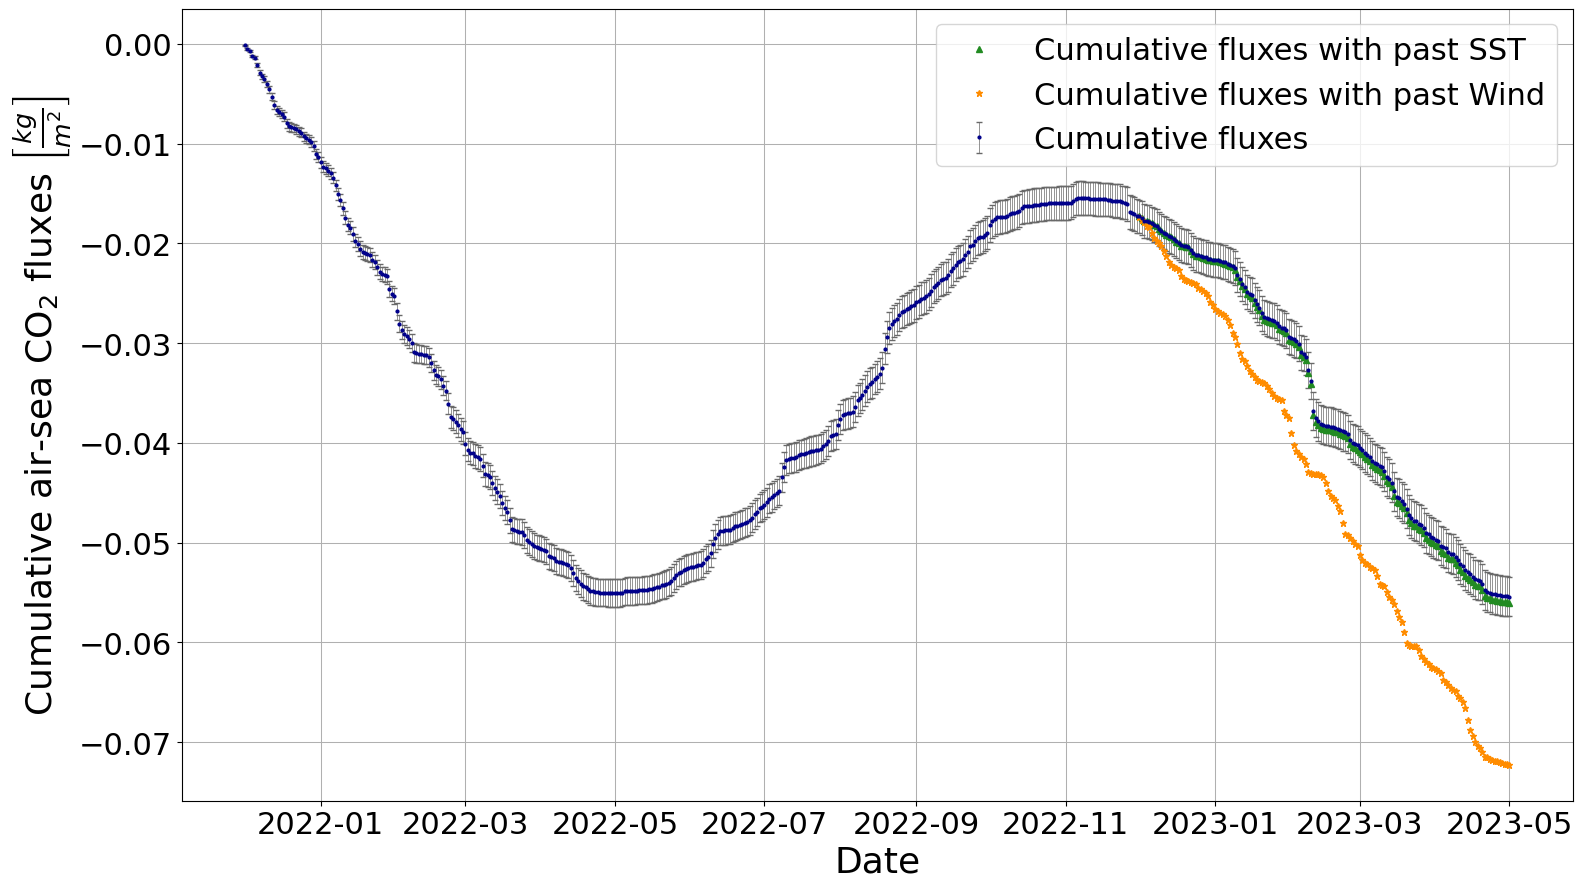

In [51]:
plt.figure(figsize=(16, 9))
ax = plt.axes()

#plt.errorbar(cumul_fluxes_interp.date, cumul_fluxes_interp.cumul_flux_nominal, yerr = cumul_fluxes_interp.cumul_flux_err, fmt='o', color = "darkblue" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5,  label = "Cumulative fluxes")
plt.errorbar(flussi_cumulati.date, flussi_cumulati.cumul_true, yerr = flussi_cumulati["cumul_true_err"], fmt='o', color = "darkblue" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5,  label = "Cumulative fluxes")

#plt.errorbar(cumul_fluxes_nointerp.date, cumul_fluxes_nointerp.cumul_flux_nominal, yerr = cumul_fluxes_nointerp.cumul_flux_err, fmt='o', color="darkgrey", markersize=2, capsize=2, ecolor = "darkorange", elinewidth=0.5)
#plt.errorbar(cumul_fluxes_w_past_sst.date, cumul_fluxes_w_past_sst.cumul_flux_nominal, yerr = cumul_fluxes_w_past_sst.cumul_flux_err, fmt='o', color = "forestgreen" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5, label = "Cumulative fluxes with past SST")
#plt.errorbar(cumul_fluxes_w_past_sst.date, cumul_fluxes_w_past_wind.cumul_flux_nominal, yerr = cumul_fluxes_w_past_wind.cumul_flux_err, fmt='o', color = "darkorange" , markersize=2, capsize=2, ecolor = "dimgrey", elinewidth=0.5, label = "Cumulative fluxes with past ind")

#plt.plot(cumul_fluxes_w_past_sst.date, cumul_fluxes_w_past_sst.cumul_flux_nominal, 'o-', color="forestgreen", markersize=2, label="Cumulative fluxes with past SST")
#plt.plot(cumul_fluxes_w_past_sst.date, cumul_fluxes_w_past_wind.cumul_flux_nominal, 'o-', color="darkorange", markersize=2, label="Cumulative fluxes with past Wind")

#taglio il df per rappresentare
flussi_cumulati_past_var = flussi_cumulati[flussi_cumulati["date"] >= dt.datetime(2022,12,1)]

plt.plot(flussi_cumulati_past_var.date, flussi_cumulati_past_var.cumul_sst, '^', color="forestgreen", markersize=5, label="Cumulative fluxes with past SST")
plt.plot(flussi_cumulati_past_var.date, flussi_cumulati_past_var.cumul_wind, '*', color="darkorange", markersize=5, label="Cumulative fluxes with past Wind")


plt.grid(lw = 0.75)

plt.xlabel("Date", fontsize = 26)
plt.ylabel(r"Cumulative air-sea CO$_2$ fluxes $\left[\frac{kg}{m^2} \right]$", fontsize = 26)

ax.yaxis.get_offset_text().set_fontsize(10)

#plt.legend()

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)
plt.tight_layout()

#plt.savefig("../20230930_cumulative_fluxes.png", dpi = 300)

PLOT LAMPEDUSA POSITION
---


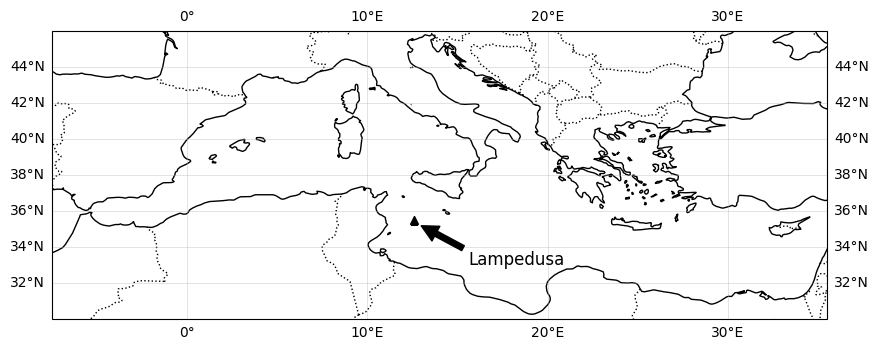

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordinates of Lampedusa
lampedusa_lat = 35.5
lampedusa_lon = 12.6

# Create a figure and an axis with Cartopy's PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map to focus on the Mediterranean Sea
ax.set_extent([-7.5, 35.5, 30, 46], crs=ccrs.PlateCarree())

# Add coastlines, borders, and gridlines
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, alpha=0.5, lw = .5)

# Add a scatter plot for Lampedusa
ax.plot(lampedusa_lon, lampedusa_lat, 'k^', transform=ccrs.PlateCarree())

# Add an arrow pointing to Lampedusa
ax.annotate(
    'Lampedusa',
    xy=(lampedusa_lon +0.25, lampedusa_lat - 0.25),
    xytext=(lampedusa_lon + 3, lampedusa_lat - 2.5),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12,
    transform=ccrs.PlateCarree()
)

# Set the title
#plt.title('Map of the Mediterranean Sea with Lampedusa')

# Show the plot
plt.show()


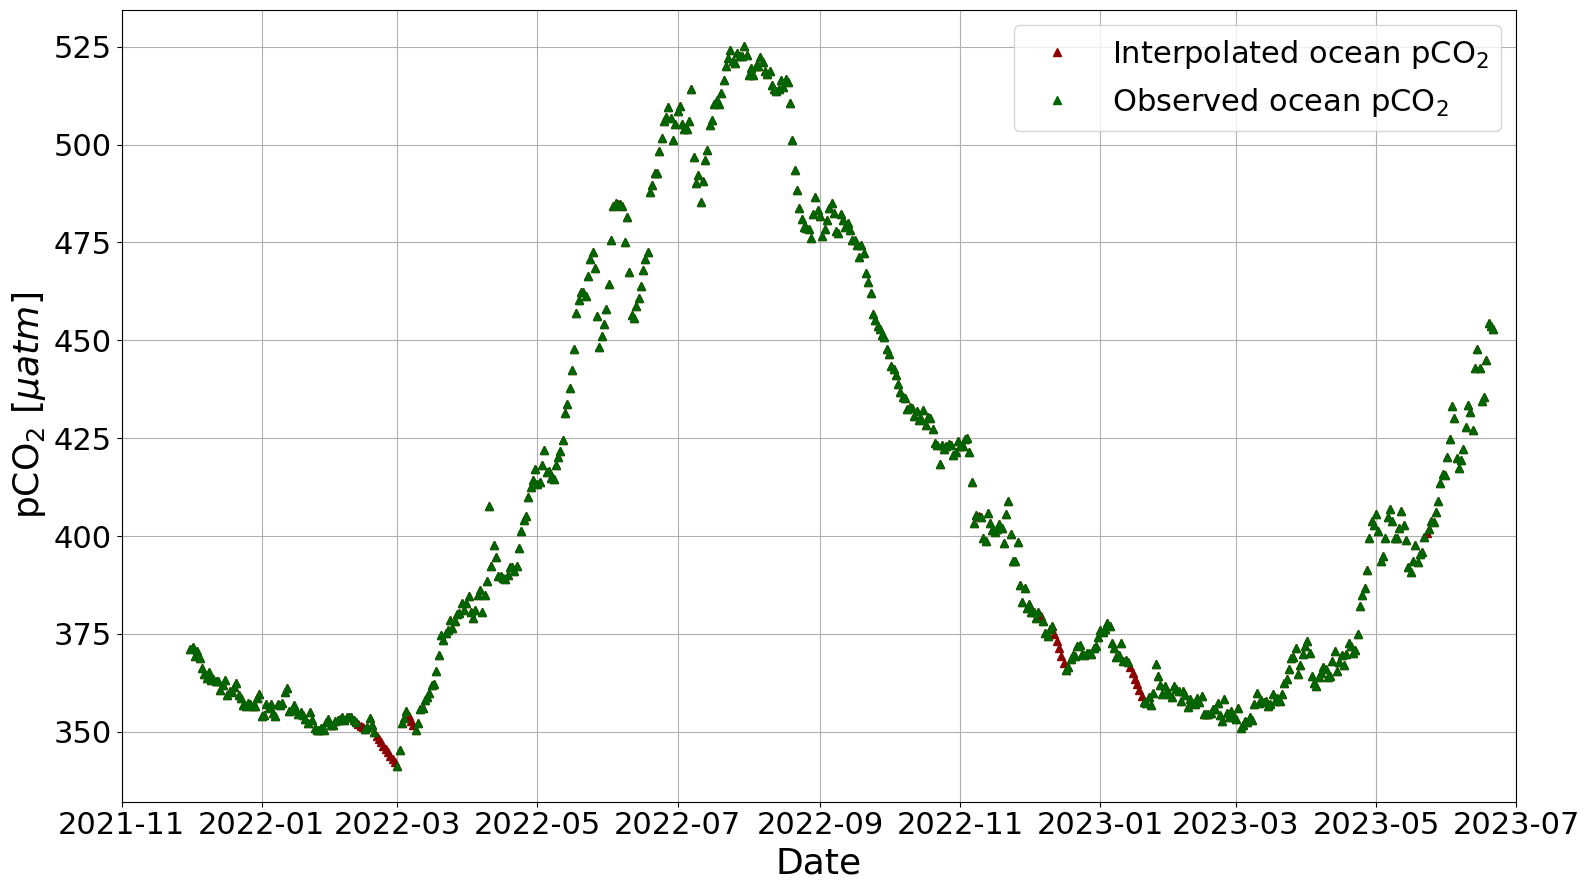

In [17]:
#plot pco2 air and sea to have a reference

plt.figure(figsize=(16, 9))

ax = plt.axes()
months = mdates.MonthLocator(interval =4)  
years = mdates.YearLocator()
y_fmt = mdates.DateFormatter('%Y')
m_fmt = mdates.DateFormatter('%b')


ax.set_xlim(dt.datetime(2021,11,1), dt.datetime(2023,7,1))


ax.plot(buoy_daily.date, buoy_daily.interp_pco2, '^',color='darkred', label=r'Interpolated ocean pCO$_2$')
ax.plot(buoy_daily.date, buoy_daily.pco2, marker = '^', lw = 0,color='darkgreen', label=r'Observed ocean pCO$_2$')




#ax.set_title("5m depth hourly density")
ax.set_xlabel("Date", fontsize = 26)
ax.set_ylabel(r"pCO$_2$ $\left[ \mu atm \right]$", fontsize = 26)
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(y_fmt)
#ax.xaxis.set_minor_locator(months)
#ax.xaxis.set_minor_formatter(m_fmt)
ax.grid(axis= "x", which = "both")
ax.grid(axis = "y", which="major")
ax.tick_params(axis='both', which='both', labelsize=22)
ax.legend(fontsize = 22)
plt.tight_layout()

#plt.savefig("../air_vs_ocean_pCO2_20230930.png", dpi = 300)

DISCRETE SAMPLES
----

In [111]:
#file containing pco2 values from the discrete samples
file_in = pd.read_csv("", sep= ";", converters = {"data": str, "Orario ut": str})

file_in = file_in.dropna(subset= ["pCO2(uatm)_corr"]).reset_index(drop=True)
file_in[["pCO2(uatm)_corr", "pCO2(uatm)_CO2Sys"]] = file_in[["pCO2(uatm)_corr", "pCO2(uatm)_CO2Sys"]].astype(float)


#I need an empty column for later
file_in["pco2_mean"] = [0 for i in range(len(file_in))]


#merge date and time
date = []
for i in range(len(file_in)):
    if file_in["Orario ut"][i]:
        date.append(pd.to_datetime(file_in["data"][i].split("/")[2] + "-" + file_in["data"][i].split("/")[1] +"-"+ file_in["data"][i].split("/")[0] + " " + file_in["Orario ut"][i].split(".")[0] + ":" + file_in["Orario ut"][i].split(".")[1] + ":00"))
    else:
        #print("not ok")
        date.append(pd.to_datetime(file_in["data"][i].split("/")[2] + "-" + file_in["data"][i].split("/")[1] +"-"+ file_in["data"][i].split("/")[0], format = "%Y-%m-%d"))


file_in["date"] = date

#read pco2 continuous data from above
pco2 = pd.read_csv("", converters= {"date" : pd.to_datetime})

pco2["pco2_val"] =  pco2.apply(lambda x: x["pco2"].split("+")[0], axis = 1)
pco2["pco2_val"] = pco2["pco2_val"].astype(float)


In [ ]:
date_campionamenti = []

for dat in file_in.data.to_list():
    print(dat)
    try:
        date_campionamenti.append(pd.to_datetime(dat))
        #print("OKAY LESGO")
    except:
        print("not a date chill top")


#cleaning  NaTs

date_campionamenti = list(filter(pd.notna, date_campionamenti))

#Remove the 00:00:00
date_campionamenti =[d.date() for d in date_campionamenti]




In [120]:

# Separae data with time from the sampling from the data without a time for the sample
file_in_with_time = file_in[file_in['date'].dt.time != pd.to_datetime('00:00:00').time()]
file_in_without_time = file_in[file_in['date'].dt.time == pd.to_datetime('00:00:00').time()]

# I found the 3 closest 2-hourly pco2 "continuous" data and I average them
def mean_of_closest_dates(target_date, pco2_data, n=3):
    # Calcolare la differenza assoluta in tempo tra la data target e tutte le date di pco2
    time_diff = abs(pco2_data['date'] - target_date)
    # Ordinare e prendere i primi n (3 in questo caso) valori più vicini
    closest_dates = pco2_data.loc[time_diff.nsmallest(n).index, 'pco2_val']
    return closest_dates.mean()

# I comput the average of the 3 closest values
for i, row in file_in_with_time.iterrows():
    target_date = row['date']
    mean_value = mean_of_closest_dates(target_date, pco2)
    file_in.loc[i, 'pCO2_mean'] = mean_value

#if i don't have the time (because they it wasnt marked) i use the daily average
for i, row in file_in_without_time.iterrows():
    target_date = row['date'].date()
    daily_mean = pco2[pco2['date'].dt.date == target_date]['pco2_val'].mean()
    file_in.loc[i, 'pCO2_mean'] = daily_mean



#I had troubles with the value from 09 march 2023, I just paste manually the value from the dataframe
    
file_in.loc[file_in.data == "09/03/2023","pCO2_mean"] = 357.189330	



In [67]:
conigli = file_in.loc[6:14, ["pCO2(uatm)_corr", "pCO2(uatm)_CO2Sys"]].reset_index(drop=True).astype(float)
boa_srfc = file_in.loc[19:21, ["pCO2(uatm)_corr", "pCO2(uatm)_CO2Sys"]].reset_index(drop=True).astype(float)
boa_5m = file_in.loc[27:32, ["pCO2(uatm)_corr", "pCO2(uatm)_CO2Sys"]].reset_index(drop=True).astype(float)

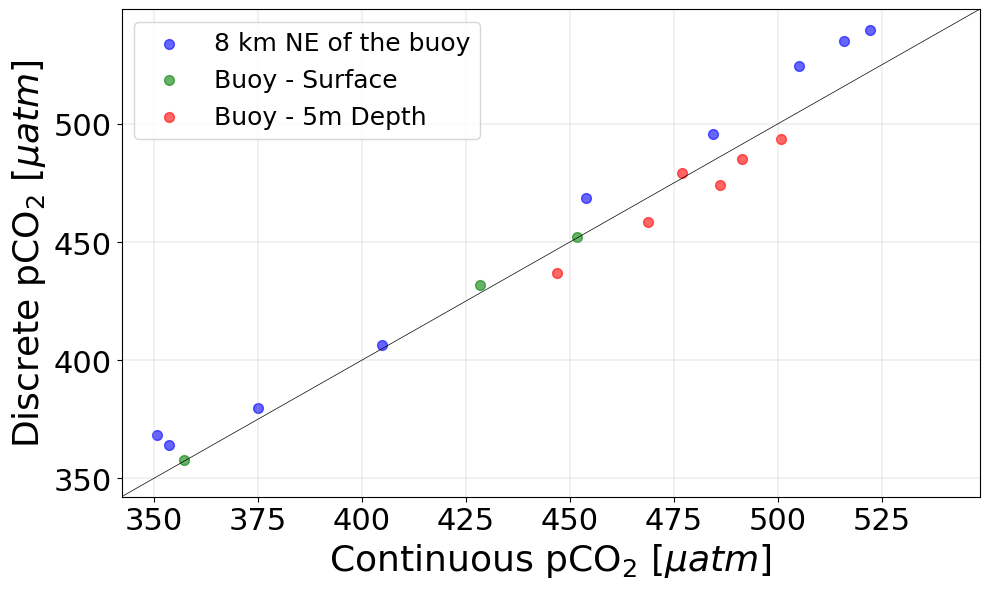

In [78]:

# Scatter plot per ciascun dataset con colori e label specifici
plt.figure(figsize=(10, 6))
ax = plt.axes()


plt.scatter(conigli["pCO2(uatm)_corr"], conigli["pCO2(uatm)_CO2Sys"], s= 50, color="blue", label="8 km NE of the buoy", alpha=0.6)
plt.scatter(boa_srfc["pCO2(uatm)_corr"], boa_srfc["pCO2(uatm)_CO2Sys"], s= 50, color="green", label="Buoy - Surface", alpha=0.6)
plt.scatter(boa_5m["pCO2(uatm)_corr"], boa_5m["pCO2(uatm)_CO2Sys"], s=50, color="red", label="Buoy - 5m Depth", alpha=0.6)

# Aggiunta di titolo e label per gli assi
#plt.title("Comparison of pCO2 Measurements Across Locations and Depths")
plt.xlabel(r"Continuous pCO$_2$ $\left[\mu atm\right]$", fontsize = 26)
plt.ylabel(r"Discrete pCO$_2$ $\left[\mu atm\right]$", fontsize = 26)

min_value = np.min([ax.get_xlim()[0], ax.get_ylim()[0]])
max_value = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
plt.tick_params(axis='both', which='both', labelsize=22)


ax.plot([min_value, max_value], [min_value, max_value], color = "black", linewidth = .5)

#setto i limiti uguali in modo che la diaognale 1:1 sia quadrata
ax.set_xlim(min_value, max_value)
ax.set_ylim(min_value, max_value)

plt.grid(lw = 0.25)


# Aggiunta della legenda
plt.legend(fontsize = 18)
plt.tight_layout()

# Mostra il grafico
plt.show()


In [79]:
discrete = pd.concat([conigli, boa_srfc, boa_5m])

In [82]:
from sklearn.metrics import  r2_score
r2_discrete = r2_score(discrete["pCO2(uatm)_corr"], discrete["pCO2(uatm)_CO2Sys"])
print(r2_discrete)

0.9592338341571396
